In [1]:
# import pandas as pd
# import numpy as np

In [2]:
# import os, time, sys, gc

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os, sys, gc, time, re, json, glob

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    PLOTABLE = True
except:
    PLOTABLE = False

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
    r2_score, explained_variance_score
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import BernoulliRBM
# from sklearn.linear_model import Ridge, ARDRegression, BayesianRidge, Lars


In [2]:
# pd.merge()

In [3]:
# from modeler import OneClassModeler

In [5]:
path = '/Users/jitins_lab/sources/ins_lookalike'
# path = '/home/ubuntu/ds_vol'
folder = 'dump_set'
path_to_json = '/Users/jitins_lab/sources/ins_lookalike/lyft_positive_nov/'

In [6]:
# df = pd.read_csv(os.path.join(path, '{}/acxiom_merged_revised.csv'.format(folder, folder)),
#                        low_memory=False)
# print('acxiom data loaded')

In [7]:
# d_cdp = pd.read_csv(os.path.join(path, '{}/cdp_weighted_zcode/cdp_weighted_zcode.csv'.format(folder, folder)),
#                        low_memory=False)
# print('cdp_weighted_zcode loaded')

In [8]:

    many_jsons = []
    for index, js in enumerate(glob.glob('{}*'.format(path_to_json))):
        with open(js) as json_file:
            r = json_file.read()
            r = '['+r.replace('\n','').replace('}','},')[:-1]+']'
            try:
                json_text = json.loads(r)
                [many_jsons.append(i) for i in json_text]
            except BaseException as e:
                print(r[:1000])
                print(e)
    df = pd.DataFrame(many_jsons)
    df.shape

(9621, 3819)

In [5]:
field_list = pd.read_csv(os.path.join(path, 'analysis/all_field_revised.csv'))

In [10]:
field_list.columns.tolist()

['FOLDER',
 'FIELD_TYPE',
 'FIELD_NAME_HEADER',
 'COLUMN_COMPLETENESS',
 'NO_OF_UNIQUE',
 'DESCRIPTION',
 'VALID_VALUES',
 'TYPE',
 'CONVERSION',
 'BLANK_HAS_VALUE',
 'IS_NON_LIKERT',
 'IS_DATE',
 'REQUIRED',
 'LOCATION',
 'SPECIAL_VARIABLES',
 'COMMENTS',
 'Min',
 'Max']

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted

class ExtendedMinMaxScaler(BaseEstimator, TransformerMixin):

    def __init__(self, feature_range=(-1, 1), na_treatment='replace', na_value=-1, treat_inf_as_na=True,
                 na_as_actual=False, data_min=None, data_max=None, copy=False, verbose=False):
        self.feature_range = feature_range
        self.copy = copy
        self.verbose = verbose
        self.na_treatment = na_treatment
        self.na_value = na_value
        self.na_as_actual = na_as_actual
        self.treat_inf_as_na = treat_inf_as_na

        if data_max is not None and isinstance(data_max, pd.DataFrame):
            self.data_max = data_max.values
        elif data_max is not None and isinstance(data_max, np.ndarray):
            self.data_max = data_max
        elif data_max is not None and (isinstance(data_max, int) or isinstance(data_max, float)):
            print('Values {} will be set as Maximum for Variables!'.format(data_max))
            self.data_max = data_max
        else:
            print("Max values not in correct format!")
            self.data_max = None

        if data_min is not None and isinstance(data_min, pd.DataFrame):
            self.data_min = data_min.values
        elif data_min is not None and isinstance(data_min, np.ndarray):
            self.data_min = data_min
        elif data_min is not None and (isinstance(data_min, int) or isinstance(data_min, float)):
            print('Values {} will be set as Minimum for Variables!'.format(data_min))
            self.data_min = data_min
        else:
            print("Min values not in correct format!")
            self.data_min = None
            

    def fit(self, X):
        """Compute the minimum and maximum to be used for later scaling.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to compute the per-feature minimum and maximum
            used for later scaling along the features axis.
        """
        X = check_array(X, copy=self.copy, ensure_2d=False, force_all_finite=False)
        feature_range = self.feature_range
        if feature_range[0] >= feature_range[1]:
            raise ValueError("Minimum of desired feature range must be smaller"
                             " than maximum. Got %s." % str(feature_range))

        if self.data_min is not None and (isinstance(self.data_min, int) or isinstance(self.data_min, float)):
            self.data_min = np.ones((1,int(X.shape[1]))) * self.data_min  
            data_min = self.data_min
        elif self.data_min is not None:
            assert len(self.data_min) == X.shape[1]
            data_min = self.data_min
        else:
            data_min = np.nanmin(X, axis=0)
            self.data_min = data_min
        
        if self.data_max is not None and (isinstance(self.data_max, int) or isinstance(self.data_max, float)):
            self.data_max = np.ones((1,int(X.shape[1]))) * self.data_max  
            data_max = self.data_max
        elif self.data_max is not None:
            assert len(self.data_max) == X.shape[1]
            data_max = self.data_max
        else:
            data_max = np.nanmax(X, axis=0)
            self.data_max = data_max

        if self.treat_inf_as_na:
            X[np.isinf(X)] = np.nan

        if self.na_treatment == 'max':
            self.na_treatment_value = data_max
        elif self.na_treatment == 'min':
            self.na_treatment_value = data_min
        elif self.na_treatment == 'max_perc':
            self.na_treatment_value = data_max * (1 + self.na_value)
        elif self.na_treatment == 'min_perc':
            self.na_treatment_value = data_min * (1 - self.na_value)
        elif self.na_treatment == 'replace':
            self.na_treatment_value = np.ones((int(X.shape[1])))* self.na_value
        else:  # default behaviour mid value of range
            self.na_treatment_value = (data_max - data_min) / 2

        data_range = data_max - data_min

        if self.verbose:
            print('Minmum Values: \n{}'.format(data_min))
            print('Maximum Values: \n{}'.format(data_max))
            print('Data_range: \n{}'.format(data_range))
            print('NA treatment values: \n{}'.format(self.na_treatment_value))

        # Do not scale constant features
        if isinstance(data_range, np.ndarray):
            data_range[data_range == 0.0] = 1.0
        elif data_range == 0.:
            data_range = 1.
        self.scale_ = (feature_range[1] - feature_range[0]) / data_range
        self.min_ = feature_range[0] - data_min * self.scale_
        self.data_range = data_range

        return self

    def transform(self, X, do_transform=True):
        """Scaling features of X according to feature_range.
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            Input data that will be transformed.
        """
        check_is_fitted(self, 'scale_')

        X = check_array(X, copy=self.copy, ensure_2d=False, force_all_finite=False)

        if self.treat_inf_as_na:
            X[np.isinf(X)] = np.nan

        mask = np.isnan(X)
        if X.shape[0] > 1:
            na_values = self.na_treatment_value * np.ones((X.shape[0], 1))
            # print(X.shape,na_values.shape)
            assert X.shape == na_values.shape
        else:
            na_values = self.na_treatment_value
            print(X.shape, na_values.shape)

        X[mask] = na_values[mask]
        if do_transform:
            X *= self.scale_
            X += self.min_

        return X

    def inverse_transform(self, X):
        """Undo the scaling of X according to feature_range.
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            Input data that will be transformed.
        """
        check_is_fitted(self, 'scale_')

        X = check_array(X, copy=self.copy, ensure_2d=False, force_all_finite=False)
        if self.treat_inf_as_na:
            X[np.isinf(X)] = np.nan
        X -= self.min_
        X /= self.scale_
        return X


In [15]:
np.ones((4))*-1

array([-1., -1., -1., -1.])

In [8]:
# # import numpy as np
# # import pandas as pd
# # import scipy as sp
# # import os, sys, gc, time

# # try:
# #     import matplotlib.pyplot as plt
# #     import seaborn as sns
# #     PLOTABLE = True
# # except:
# #     PLOTABLE = False

# # from sklearn.preprocessing import MinMaxScaler
# # from sklearn.neighbors import LocalOutlierFactor
# # from sklearn.covariance import EllipticEnvelope
# # from sklearn.ensemble import IsolationForest
# # from sklearn.model_selection import train_test_split

# # from sklearn.linear_model import LinearRegression, Lasso
# # from sklearn.svm import LinearSVR
# # from sklearn.metrics import mean_squared_error, mean_absolute_error, \
# #     r2_score, explained_variance_score
# # from sklearn.feature_selection import SelectFromModel


# # from sklearn.svm import OneClassSVM
# # from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,
# # GradientBoostingRegressor
# # from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA,
# # TruncatedSVD,KernelPCA
# # from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# # from sklearn.feature_extraction.text import CountVectorizer,
# # TfidfVectorizer,TfidfTransformer
# # from sklearn.neural_network import BernoulliRBM
# # from sklearn.linear_model import Ridge, ARDRegression, BayesianRidge, Lars



# def mean_absolute_percentage_error(y_true,y_pred):
#     non_zero = np.where(y_true != 0)
#     y_true = y_true[non_zero]
#     y_pred = y_pred[non_zero]
    
#     return np.mean(np.abs((y_true-y_pred)/y_true)) *100
                   
# def scores_con(y_true, y_pred, name='Scores'):
#     mse = mean_squared_error(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     mape = mean_absolute_percentage_error(y_true, y_pred)
#     corr = np.corrcoef(y_true, y_pred)[0, 1]
#     r2 = r2_score(y_true, y_pred)
#     exvar = explained_variance_score(y_true, y_pred)
#     print('{}: MSE: {:5.6f} MAE: {:5.6f} MAPE: {:5.6f} Corr: {:5.6f} R2: {:5.6f} ExpVar: '
#           '{:5.6f}'.format(name, mse, mae, mape, corr, r2, exvar))
                   
# class TimerAndPlotter:

#     def __init__(self, verbosity=0, plot_it=False, keep_time=False,
#                  save_fig=False):
#         self.verbosity = verbosity
#         self.plot_it = plot_it
#         self.keep_time = keep_time
#         self.save_fig = save_fig
#         self.time = None

#     def plot_componenets(self, df, name, figsize=(15,15)):
        
#         plt.figure(figsize=figsize)
#         # Create an instance of the PairGrid class.
#         grid = sns.PairGrid(data=df, size=4)
        
#         # Map a scatter plot to the upper triangle
#         grid = grid.map_upper(plt.scatter, color='darkred')
#         # grid = grid.map_upper(corr_pair)
        
#         # Map a histogram to the diagonal
#         grid = grid.map_diag(plt.hist, bins=10, color='darkred',
#                              edgecolor='k')
        
#         # Map a density plot to the lower triangle
#         grid = grid.map_lower(sns.kdeplot, cmap='Reds')
        
#         # final tweaks
#         fig = grid.fig
#         fig.subplots_adjust(top=0.93, wspace=0.3)
#         fig.suptitle(name, fontsize=14,
#                      fontweight='bold')
        
#         if self.save_fig:
#             fig.savefig('{}.png'.format(name).replace(' ','_'))

#     def plot_heatmap(self):
#         pass

#     def plot_variable(self, data, stat=None, plt_type='line', name=None, legend = None,
#                       figszie=(15,7), xticks=None, savefig=False, show=True):
        
#         if xticks is not None:
#             assert data.shape[0] == len(xticks)
            
#         plt.figure(figsize=(15,7))
        
#         if stat == 'nas':
#             x = np.sum(np.isnan(data), axis=0)
#         else:
#             x = data
        
#         if plt_type == 'line':
#             plt.plot(x, label = '' if legend is None else legend)
#         elif plt_type == 'hist':
#             plt.hist(x, bins=50, label = '' if legend is None else legend)
#         else:
#             plt.plot(x, label = '' if legend is None else legend)
        
#         if xticks is not None:
#             plt.xticks(xticks)
        
#         if name is not None:
#             plt.title(name)
        
#         if legend is not None:
#             plt.legend()

#         if show:
#             plt.show()
        
#         if self.save_fig:
#             try:
#                 assert name is not None
#                 plt.savefig('{}.png'.format(name).replace(' ','_'))
#             except Exception as e:
#                 print('Got Error while saving : \'name\' not set',e)
#                 pass
        

#     def print_stats(self, data, y=None, stat_type='full',name=None,msg=None):
        
#         if msg is not None:
#             print(msg)
#         if stat_type == 'full':
#             stat_name = 'Stat' if name is None else name
#             x = data.flatten()
#             vals = np.percentile(x,[0,25,50,75,100])
#             print('{} : Min: {:5.6f} 25%: {:5.6f} Median: {:5.6f} 75%: {:5.6f} Max :{:5.6f} Mean: {:5.6f} Std: {:5.6f}'.format(
#                 stat_name,vals[0],vals[1],vals[2],vals[3],vals[4],np.mean(x),np.std(x)))
#         elif stat_type == 'metric':
#             if y is None:
#                 raise ValueError('Meric cannot be evaluated without true values')
#             stat_name = 'Metric' if name is None else name
#             scores_con(y,data,name=stat_name)
#         elif stat_type == 'nas':
#             shp = data.shape
#             nas = np.sum(np.isnan(data))
#             print('Na Counts: {} Na%: {:5.2f}'.format(nas,nas / np.prod(shp)))
#         elif stat_type == 'basic':
#             shp = data.shape
#             nas = np.sum(np.isnan(data))
#             print('Shape: {} Na Counts: {} Na%: {:5.2f}'.format(shp, nas, (nas/np.prod(shp)*100 )))
#         else: # default
#             shp = data.shape
#             nas = np.sum(np.isnan(data))
#             print('Shape: {} Na Counts: {} Na%: {:5.2f}'.format(shp, nas, (nas/np.prod(shp)*100 )))
#             self.print_stats(data,stat_type='full')
    
#     def print_msg(self,value,msg):
#         print(msg,value)
            
#     def start_time(self):
#         self.time=time.time()

#     def tell_time(self,t,msg=None,reset=False):
#         if self.time is None:
#             print('Timer not started')
#         if msg is None:
#             print('The process took {:5.4f} secs'.format((self.time - t)))
#         else:
#             print('{} : {:5.4f} secs'.format(msg,(self.time - t)))

#         if reset:
#             self.start_time()
#         self.keep_timer(True)

#     def keep_timer(self,t_secs=0,finalize=False):
#         pass


# class OneClassModeler(object):

#     def __init__(self, n_components=30, contamination=0.1, confidence_bounds=0.5, cdp_evidence=10,
#                  n_clusters=3, cluster_weights='infer', na_to_model='drop', use_prediction=False,
#                  na_to_score='max_perc', evaluate_seed=False, do_scaling=False,
#                  verbosity=0, plot_it=False, keep_time=False,
#                  save_fig=False):

#         self.num_components = n_components
#         self.contamination = contamination
#         self.confidence_bounds = confidence_bounds
#         self.use_prediction = use_prediction
#         self.cdp_evidence = cdp_evidence

#         self.n_clusters = n_clusters
#         self.cluster_weights = cluster_weights
#         self.na_to_model = na_to_model
#         self.na_to_score = na_to_score
#         self.evaluate_seed = evaluate_seed
#         self.do_scaling = do_scaling
#         self.timer_plotter = TimerAndPlotter(verbosity, plot_it, keep_time,
#                                              save_fig)
        
#         # Manually defining batch size as of now
#         self.batch_size = 1000

#         self.batch_data = None
#         self.cdp_models = None
#         self.oneclass_models = None
#         self.max_components_df = None
#         self.field_data = None
#         self.grouped_cdp = None
#         self.components_df = None
#         self.selected_fields = None
#         self.cdp_columns = None

#     def __remove_dup(self, duplicate):
#         final_list = []
#         dups = []
#         for num in duplicate:
#             if num not in final_list:
#                 final_list.append(num)
#             else:
#                 dups.append(num)
#         # print(dups)
#         return final_list

#     def fit(self, X_acxiom, X_cdp, fields_data):

#         # assigning data for internal usage
#         df = X_acxiom.copy()
#         d_cdp = X_cdp.copy()
#         field_list = fields_data.copy()

#         #field_list.fillna(value=False, inplace=True)
#         print(field_list.head())

#         # selecting continuous columns from acxiom data
#         avail_columns = df.columns
#         con_fields = field_list.FIELD_NAME_HEADER[
#             field_list['TYPE'] == 'Continuous'].values.tolist()

#         con_avail = []
#         for i_c in avail_columns:
#             for j in con_fields:
#                 i = i_c.split('|')[0]
#                 if i == j:
#                     con_avail.append(i_c)
#                 elif str(i).startswith(j[:8]) and not i.startswith('foc'):
#                     print('same fields?: {} {}'.format(i, j))
#                     con_avail.append(i_c)
#                 elif i.startswith('foc') and str(i).startswith(j[:12]):
#                     print('same fields?: {} {}'.format(i, j))
#                     con_avail.append(i_c)
#                 else:
#                     pass

#         print(len(con_avail))
#         con_avail = self.__remove_dup(con_avail)
#         print(len(con_avail))

        
#         self.timer_plotter.print_stats(df[con_avail].values,stat_type='nas')
#         self.timer_plotter.plot_variable(df[con_avail].values,stat='nas',
#                                          name='Nas Value without filtering Columns')
        
#         # removing columns based on nas, std and max values
#         stat_df = pd.DataFrame({'con_fields': con_avail,
#                                 'nas': np.sum(np.isnan(df[con_avail].values), axis=0)})
#         stat_df['thres'] = stat_df['nas'] < np.percentile(stat_df['nas'].values,
#                                                           93.6)

#         self.timer_plotter.print_stats(df[stat_df[stat_df['thres']]['con_fields'].values].values,
#                                        stat_type='nas')
        
#         self.timer_plotter.plot_variable(df[stat_df[stat_df['thres']]['con_fields'].values].values,
#                                          stat='nas',
#                                          name='Nas Value with filtered Columns')

#         df_con = df[stat_df[stat_df['thres']]['con_fields'].values].copy(
#             deep=True)
        
#         self.timer_plotter.print_stats(df_con.values,stat_type='basic',msg='Shape with out dropping Nas')
#         df_con.dropna(inplace=True)
#         self.timer_plotter.print_stats(df_con.values,stat_type='basic',msg='Shape after dropping Nas')

#         col_std = np.std(df_con.values, axis=0)
#         col_max = np.max(df_con.values, axis=0)
        
#         self.timer_plotter.print_msg(df_con.columns[(col_std == 0.0)],msg = 'Columns with zero standard deiviation')
#         self.timer_plotter.print_msg(df_con.columns[(col_std > np.percentile(col_std, 99.75))],
#                                      msg = 'Columns with very high standard deiviation')
#         self.timer_plotter.print_msg(df_con.columns[(col_max < 8)],msg = 'Columns wich are descrete yet continuous')
#         self.timer_plotter.print_msg(df_con.columns[(col_std == 0.0) | (
#                 col_std > np.percentile(col_std, 99.75)) | (col_max < 8)],msg = 'Overall Dropable Columns')
        
#         df_con2 = df_con.drop(df_con.columns[(col_std == 0.0) | (
#                 col_std > np.percentile(col_std, 99.75)) | (col_max < 8)],
#                               axis=1).copy(deep=True)
#         self.timer_plotter.print_stats(df_con2.values,stat_type='basic',msg='Final usable Acxiom dataset')
        
#         # using extended min max scalaer for scaling as well as na imputation
#         min_vals = []
#         max_vals = []
#         for fields in df_con2.columns:
#             field = fields.split('|')[0]
#             min_vals.append(field_list.Min[field_list.FIELD_NAME_HEADER == field].values)
#             max_vals.append(field_list.Max[field_list.FIELD_NAME_HEADER == field].values)
        
#         min_vals = np.array(min_vals).reshape(-1)
#         max_vals = np.array(max_vals).reshape(-1)
#         minmaxer = ExtendedMinMaxScaler(na_treatment=self.na_to_score, na_value=0.25,
#                                 data_min=min_vals,
#                                 data_max =max_vals
#                                 ).fit(df_con2)
#         self.minmaxer = minmaxer
#         del df_con
#         # del df
#         gc.collect()

#         # doing pca
#         cov_mat = np.cov(df_con2.values.T)
#         plt.figure(figsize=(12, 10))
#         sns.heatmap(np.log(cov_mat))
#         plt.savefig('CovMat_heatmap.png')
#         num_fields = int(cov_mat.shape[0])
#         eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
#         eig_val_cov, eig_vec_cov = sp.linalg.cdf2rdf(eig_val_cov, eig_vec_cov)
#         non_unit_cov_ev = []
#         for i, ev in enumerate(eig_vec_cov):
#             try:
#                 np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
#             except:
#                 print('{} this one does not have unit val {}'.format(i,
#                                                                      np.linalg.norm(
#                                                                          ev)))
#                 non_unit_cov_ev.append(i)
#             # instead of 'assert' because of rounding errors
#         non_unit_cov_ev = np.array(non_unit_cov_ev)

#         # Make a list of (eigenvalue, eigenvector) tuples
#         eig_pairs_cov = [(np.sum(eig_val_cov[i]), eig_vec_cov[:, i]) for i in
#                          range(len(eig_val_cov))]

#         # Sort the (eigenvalue, eigenvector) tuples from high to low
#         eig_pairs_cov.sort(key=lambda x: x[0], reverse=True)

#         explained_vec_cov = []
#         # Visually confirm that the list is correctly sorted by decreasing eigenvalues
#         for i in eig_pairs_cov:
#             explained_vec_cov.append(i[0])
        
#         self.timer_plotter.plot_variable(explained_vec_cov[:self.num_components],
#                                          stat='line',
#                                          name='PCA Scree Plot')
#         matrix_w_cov = np.array(
#             [eig_pairs_cov[i][1] for i in range(self.num_components)]).T

#         # matrix_w_cov.reshape(20,1953).T.shape
#         self.timer_plotter.print_stats(matrix_w_cov,stat_type='',msg='Component Loadings\' Matrix: ')
#         gc.collect()

#         components_df = pd.DataFrame(matrix_w_cov >= 0, index=df_con2.columns,
#                                      columns=['P_{}'.format(i) for i in
#                                               range(1, self.num_components + 1)])
        
#         # design heat map here
#         plt.figure(figsize=(15, 20))
#         sns.heatmap(components_df.sort_values(
#             ['P_{}'.format(i) for i in range(1, self.num_components + 1)],
#             ascending=[False for _ in range(1, self.num_components + 1)]))
#         plt.savefig('PCA_Component_distribution.png')

#         max_components_df = pd.DataFrame({'Columns': components_df.index,
#                                           'Components': components_df.idxmax(
#                                               axis=1)}).groupby(
#             ['Components']).agg(lambda x: list(x))

        
#         self.max_components_df = max_components_df
#         self.components_df = components_df

#         df_transformed = self._transform_acxiom(df_con2)
        
#         gc.collect()
        
#         # Fitting one class model
#         mod_lof = LocalOutlierFactor(contamination=self.contamination, n_jobs=-1, p=3,novelty=True,
#                                      leaf_size=2, n_neighbors=10)
#         mod_if = IsolationForest(behaviour="new",n_estimators=50, max_features=3,
#                                     contamination=self.contamination)
#         mod_cov = EllipticEnvelope(support_fraction=0.1, assume_centered=True,
#                                    contamination=self.contamination)
#         X_train, X_test = train_test_split(df_transformed.values, test_size=0.2)

#         mod_lof.fit(X_train)
#         mod_if.fit(X_train)
#         mod_cov.fit(X_train)

#         # Evaluating one class models
#         # Local Outline factor
#         act = mod_lof.kneighbors(X_train)
#         self.timer_plotter.plot_variable(act[0].flatten(),plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Distance for LOF with Training Data')
#         self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
#         self.timer_plotter.plot_variable(np.log(-mod_lof.negative_outlier_factor_),plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Log LOF score with Training Data')
#         self.timer_plotter.print_stats(np.log(-mod_lof.negative_outlier_factor_),stat_type='full')
        
#         act = mod_lof.kneighbors(X_test)
#         self.timer_plotter.plot_variable(act[0].flatten(),plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Distance for LOF with Testing Data')
#         self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
#         act = mod_lof.predict(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of LOF Prediction with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_lof.decision_function(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Decision Value for LOF with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_lof.score_samples(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Sample LOF Score for LOF with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         # Isolation Forest
#         act = mod_if.predict(X_train)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of IForest Prediction with Training Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_if.decision_function(X_train)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Decision Value for Isolation Fores with Training Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_if.predict(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Isolation Forest Prediction with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_if.decision_function(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Decision Value for Isolation Forest with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         # Robust Covariance
#         act = mod_cov.predict(X_train)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Robust Covariance Prediction with Training Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_cov.decision_function(X_train)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Decision Value for Robust Covariance with Training Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         act = mod_cov.predict(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Robust Covariance Prediction with Testing Data')
#         self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
#         act = mod_cov.decision_function(X_test)
#         self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
#                                          name='Histogram of Decision Value for Robust Covariance with Testing Data')
#         self.timer_plotter.print_stats(act,stat_type='full')
        
#         if self.use_prediction:
#             df_norm = pd.DataFrame(
#                 {'if_score': mod_if.predict(df_transformed.values),
#                  'cov_score': mod_cov.predict(df_transformed.values),
#                  'lof_distance': mod_lof.predict(df_transformed.values)})
#             df_norm['score'] = df_norm[
#                 ['if_score', 'cov_score', 'lof_distance']].sum(axis=1)
            
#         else:
#             df_scores = pd.DataFrame(
#                 {'if_score': mod_if.decision_function(df_transformed.values),
#                  'cov_score': mod_cov.decision_function(df_transformed.values),
#                  'lof_distance': np.mean(mod_lof.kneighbors(df_transformed.values)[0], axis=1)})


#             score_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df_scores.values)
#             df_norm = pd.DataFrame(score_scaler.transform(df_scores.values),
#                                    columns=df_scores.columns)
#             df_norm.lof_distance = - df_norm.lof_distance
        

#             df_norm['score'] = df_norm[
#                 ['if_score', 'cov_score', 'lof_distance']].mean(axis=1)
            
#         self.timer_plotter.print_msg(df_norm.corr(),'\nCorelation of Scores\n')

#         self.timer_plotter.print_msg((df.shape, df_con2.shape, df_transformed.shape, df_norm.shape),
#                                      '\nShapes of Original df, Subsetted df, Transformed df, Scored df')
#         df_norm['email_address_md5'] = df.loc[df_con2.index, 'email_address_md5']
        
#         self.timer_plotter.plot_variable(df_norm['score'].values, plt_type='hist', figszie=(10,5),
#                                          name='Histogram of Acxiom Scores to predict by CDP data')
#         self.timer_plotter.print_stats(df_norm['score'].values,stat_type='full',name='Score stat to predict: ')
        
#         # dealing with cdp data
#         stat_df_cdp = pd.DataFrame(
#             {'con_fields': d_cdp.drop('email_address_md5', axis=1).columns,
#              'nas': np.sum(
#                  np.isnan(d_cdp.drop('email_address_md5', axis=1).values),
#                  axis=0)})
        
#         col_std_cdp = np.nanstd(d_cdp.drop('email_address_md5', axis=1).values,
#                                 axis=0)
#         col_max_cdp = np.nanmax(d_cdp.drop('email_address_md5', axis=1).values,
#                                 axis=0)
#         self.timer_plotter.print_msg(d_cdp.drop('email_address_md5', axis=1).columns[(col_max_cdp == 0)],
#                                      'CDP columns with 0 as max')
#         self.timer_plotter.print_msg(d_cdp.drop('email_address_md5', axis=1).columns[(col_std_cdp == 0)],
#                                      'CDP columns with 0 as std')
                                     
#         cdp_drop = d_cdp.drop('email_address_md5', axis=1).columns[
#             (col_max_cdp == 0) | (col_std_cdp == 0)]

#         df_cdp = d_cdp.drop(cdp_drop, axis=1)
#         self.timer_plotter.print_msg(df_cdp.shape,'CDP Data : ')
#         df_cdp.dropna(inplace=True)

#         cdp_df = pd.merge(df_cdp, df_norm[['email_address_md5', 'score']],
#                           on='email_address_md5')
#         self.timer_plotter.print_msg(cdp_df.shape,'CDP Data with one clas scores in Acxiom dataset: ')
        
#         col_var = cdp_df.drop(['email_address_md5', 'score'], axis=1).columns
#         grouped_cdp = cdp_df.drop(['email_address_md5'], axis=1).copy(deep=True)
#         grouped_cdp = grouped_cdp.groupby(col_var.tolist(), sort=False).agg(
#             ['sum', 'mean', 'median', 'std', 'max', 'min', 'count'])
#         grouped_cdp.columns = grouped_cdp.columns.droplevel(0)
#         grouped_cdp = grouped_cdp.reset_index()
#         grouped_cdp['score'] = grouped_cdp['median']
#         grouped_cdp['weight'] = grouped_cdp['count'] / np.sum(
#             grouped_cdp['count'])
#         grouped_cdp.drop(
#             ['sum', 'mean', 'median', 'std', 'max', 'min', 'count'], axis=1,
#             inplace=True)

#         cdp_col = grouped_cdp.drop('score',axis=1).sum().index[grouped_cdp.drop('score',axis=1).sum().values >= self.cdp_evidence].tolist()
#         X_train_cdp, X_test_cdp, y_train_cdp, y_test_cdp = train_test_split(
#             grouped_cdp[cdp_col],
#             grouped_cdp.score.values, test_size=0.1)
        
#         self.timer_plotter.print_msg(grouped_cdp[cdp_col].shape,'CDP Data for training: ')
        
#         # training models for cdp to fit on scores by one class model
#         lin = LinearRegression().fit(X_train_cdp, y_train_cdp)
#         i = 0.0001
#         las = Lasso(alpha=i, tol=0.000001, precompute=True,
#                     selection='random').fit(X_train_cdp, y_train_cdp)
#         scores_con(y_train_cdp, las.predict(X_train_cdp),
#                name='Train Lasso Model {}'.format(i))
#         scores_con(y_test_cdp, las.predict(X_test_cdp),
#                name='Test Lasso Model {}'.format(i))
#         i=0.001
#         rdg = Ridge(alpha=i, solver='lsqr',tol=0.000001).fit(X_train_cdp,y_train_cdp)
#         scores_con(y_train_cdp,rdg.predict(X_train_cdp),name = 'Train Ridge Model {}'.format(i))
#         scores_con(y_test_cdp,rdg.predict(X_test_cdp),name = 'Test Ridge Model {}'.format(i))
#         rfs = RandomForestRegressor(n_estimators=60,n_jobs=-1, min_samples_split=9, min_samples_leaf=9).fit(X_train_cdp,y_train_cdp)
#         etr = ExtraTreesRegressor(n_estimators=60,n_jobs=-1, min_samples_split=9, min_samples_leaf=9).fit(X_train_cdp,y_train_cdp)
#         scores_con(y_train_cdp,rfs.predict(X_train_cdp),name = 'Train RF  Model')
#         scores_con(y_test_cdp,rfs.predict(X_test_cdp),name = 'Test RF  Model ')
#         scores_con(y_train_cdp,etr.predict(X_train_cdp),name = 'Train ET  Model')
#         scores_con(y_test_cdp,etr.predict(X_test_cdp),name = 'Test ET  Model ')
        

#         self.cdp_models = [lin, las, rdg, rfs, etr]
#         self.oneclass_models = [mod_if, mod_cov, mod_lof]
#         self.field_data = field_list
#         self.grouped_cdp = grouped_cdp
#         self.selected_fields = self.components_df.index.tolist()
#         self.cdp_columns = cdp_col
        
#     def _transform_acxiom(self,X):
        
#         df_transformed = pd.DataFrame(index=X.index)
#         for indx in self.max_components_df.index:
#             if self.do_scaling:
#                 comp_data = MinMaxScaler().fit_transform( X[self.max_components_df.loc[indx, 'Columns']].values)
#             else:
#                 comp_data = X[self.max_components_df.loc[indx, 'Columns']].values
#             comp_coeff = self.components_df.loc[self.max_components_df.loc[indx, 'Columns'], indx].values
#             df_transformed[indx] = comp_data.dot(comp_coeff)

#         print(df_transformed.head())
#         return df_transformed
    
#     def _na_value_mapper(self,X,x_type='acxiom'):
#         if x_type == 'acxiom' :
#             pass
#         elif x_type == 'cdp':
#             pass
#         else:
#             raise ValueError('X type shold be \'axiom\' or \'cdp\' ')

#     def _predict(self, X):
#         pass

#     def _extract_data_acxiom(self, dict_fields, fields):

# #         dict_fields = {"ap006095": 1, "ap006094": 1}
# #         fields = [i.split('|')[0] for i in oneclass.selected_fields]
# #         folders = [i.split('|')[1] for i in oneclass.selected_fields]
#         alist = [[fields.index(k), v] for k, v in
#                  dict_fields.items()]
#         # alist
#         # [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
#         X = np.zeros((1, len(fields)))
#         X[:] = np.nan
#         for k, v in alist: X[:, k] = v

#         return X
    
#     def _extract_data_cdp(self, dict_fields):
# #         dict_fields = {"z145": 1, "z254": 1}
#         alist = [[self.cdp_columns.index(k), v] for k, v in
#                  dict_fields.items()]
#         # alist
#         # [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
#         X = np.zeros((1, len(self.cdp_columns)))
#         X[:] = np.nan
#         for k, v in alist: X[:, k] = v
#         return X
    
#     def _extract_data(self, dict_fields,fields):
#         dict_fields = {}
#         keys = dict_fields.keys()
#         cdp_dict = { k:v for k,v in dict_fields.items() if str(k).startswith('z') }
#         acxiom_dict = { k:v for k,v in dict_fields.items() if not str(k).startswith('z') }
#         return self._extract_data_acxiom(acxiom_dict, fields), self._extract_data_cdp(cdp_dict)
        

#     def score(self, user_data):

#         """
#         Scorer::score()
#         def score(user_data):
#             return [(user_id, score), (user_id, score), (user_id, score), ...]

#         Parameters:
#         user_data: an iterable of (user_id, dict) tuples.  Each dict is a sparse
#         representation of a user's properties and most recent behavioral events.

#         Returns:        List of (user_id, score) tuples, where score is a float.
#         """

#         user_ids = None
#         X_acx = np.zeros((1, len(self.selected_fields)))
#         X_cdp = np.zeros((1, len(self.cdp_columns)))
#         fields = [i.split('|')[0] for i in self.selected_fields]
#         folders = [i.split('|')[1] for i in self.selected_fields]

#         if isinstance(user_data, dict):
#             user_ids = user_data.keys()
#             for user_id in user_ids:
#                 acx_x, cdp_x = self._extract_data(user_data[user_id],fields)
#                 X_acx = np.vstack((X_acx,acx_x))
#                 X_cdp = np.vstack((X_cdp,cdp_x))
#                 # X = np.vstack((X, self._extract_data(user_data[user_id])))

#         elif isinstance(user_data, list):
#             user_ids = []
#             for i in user_data:
#                 user_ids.append(i[0])
#                 acx_x, cdp_x = self._extract_data(i[1],fields)
#                 X_acx = np.vstack((X_acx,acx_x))
#                 X_cdp = np.vstack((X_cdp,cdp_x))
#                 #X = np.vstack((X, self._extract_data(i[1])))
#             # X = X[1:, ]

#         elif isinstance(user_data, pd.DataFrame):
#             if 'email_address_md5' in user_data.columns:
#                 user_ids = user_data['email_address_md5']
#                 X = user_data[
#                     [i for i in user_data.columns if i != 'email_address_md5']]
#             else:
#                 print(
#                     'Data dosent have email md5s. Please check the input! '
#                     'Returning None')
#                 return None
#         elif isinstance(user_data, np.ndarray):
#             X = user_data
#             assert X.shape[1] == len(self.selected_fields) + len(self.cdp_columns)
#             X_acx = X[:,:len(self.selected_fields)]
#             X_cdp = X[:,len(self.selected_fields):]
#             print('No user ids provided. Will return a list of scores!')
#         else:
#             raise ValueError('Input data {} is not iterable'.format(user_data))
#         #
#         # if len(user_ids) > self.batch_size:
#         #     pass
#         # else:
#         X_acx = pd.DataFrame(X_acx, columns=self.selected_fields)
#         X_cdp = pd.DataFrame(X_cdp, columns=self.cdp_columns)
#         return X_acx, X_cdp
# #         score = self._predict(X).tolist()

# #         if len(user_ids) == len(score) - 1:
# #             score = score[1:]
# #         else:
# #             assert len(user_ids) == len(score)

# #         scores = list(zip(user_ids, score))
# #         return scores

#     def scorer_hints(self):
#         # print('Required Fields: \n{}'.format(self.selected_fields))
#         # print('Batch Size: {} '.format(self.batch_size))

#         stats = self.field_data
#         unique_cols = np.unique([i.split('|')[0] if str(i).rfind('|') else i for i in self.selected_fields]).tolist()
#         stats.columns = [i.lower() for i in stats.columns]
#         dict_fields = stats[stats.field_name_header.isin(unique_cols)][
#             ['folder', 'field_name_header']] \
#             .groupby('folder').agg(lambda x: x.tolist()).to_dict()
#         dict_fields = {'acxiom': dict_fields, 'cdp' :  self.cdp_columns}
#         return self.batch_size, self.selected_fields, dict_fields


In [10]:
np.clip(np.arange(-25,25).reshape(5,10),-5,5)

array([[-5, -5, -5, -5, -5, -5, -5, -5, -5, -5],
       [-5, -5, -5, -5, -5, -5, -5, -5, -5, -5],
       [-5, -4, -3, -2, -1,  0,  1,  2,  3,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5]])

In [10]:
df_acxiom = df[[i for i in df.columns if not str(i).startswith('z')]].copy()
df_cdp = df[[i for i in df.columns if str(i).startswith('z')]].copy()
df_acxiom.shape,df_cdp.shape

NameError: name 'df' is not defined

In [ ]:
def col_f(x,return_field=False): 
    y = x.split('__'); 
    if len(y) != 2:
        print(y,x)
    if return_field:
        return y[1]
    else:
        return '{}|{}'.format(y[1],y[0]) if len(y) == 2 else x
# cols = [col_f(i) for i in df_acxiom.columns]

acx_cols = [col_f(i) for i in df_acxiom.columns]
# df_acxiom.columns = 


In [95]:
df_acxiom.columns

Index(['acxiom_enh_basic_demo__ibe2350', 'acxiom_enh_basic_demo__ibe2351',
       'acxiom_enh_basic_demo__ibe2354', 'acxiom_enh_basic_demo__ibe2356',
       'acxiom_enh_basic_demo__ibe2360', 'acxiom_enh_basic_demo__ibe2403',
       'acxiom_enh_basic_demo__ibe2526', 'acxiom_enh_basic_demo__ibe2807',
       'acxiom_enh_basic_demo__ibe4000', 'acxiom_enh_basic_demo__ibe4160',
       ...
       'acxiom_enh_retail_3__ap005534', 'acxiom_enh_retail_3__ap005712',
       'acxiom_v_zeta_identity__city_name',
       'acxiom_v_zeta_identity__country_cd',
       'acxiom_v_zeta_identity__plus4_cd', 'acxiom_v_zeta_identity__postal_cd',
       'acxiom_v_zeta_identity__state_province_cd',
       'acxiom_v_zeta_identity__zip_cd', 'dt', 'email_md5'],
      dtype='object', length=2930)

In [64]:
field_list.columns

Index(['FOLDER', 'FIELD_TYPE', 'FIELD_NAME_HEADER', 'COLUMN_COMPLETENESS',
       'NO_OF_UNIQUE', 'DESCRIPTION', 'VALID_VALUES', 'TYPE', 'CONVERSION',
       'BLANK_HAS_VALUE', 'IS_NON_LIKERT', 'IS_DATE', 'REQUIRED', 'LOCATION',
       'SPECIAL_VARIABLES', 'COMMENTS', 'Min', 'Max', 'merged_names'],
      dtype='object')

In [65]:
field_list.FOLDER.unique()

array(['enh_mde_orig', 'enh_retail_2', 'enh_ins_tel_b2b', 'zeta_identity',
       'enh_misc_ap', 'enh_retail_3', 'enh_cpg', 'enh_retail_1',
       'enh_in_market', 'enh_political'], dtype=object)

In [66]:
field_list['merged_names'] = field_list[['FOLDER','FIELD_NAME_HEADER']].apply(lambda x: 'acxiom_{}__{}'.format(x[0],x[1]), axis=1)

In [67]:
# field_list[field_list.merged_names.isin(df_acxiom.columns)]

In [74]:
df_acxiom.shape,field_list.shape

((1899, 2930), (2735, 19))

In [96]:
# drop_col = ['dt','email_md5']
# for col_ in df_acxiom.columns:
# #     if col_.split('__')[0] not in ['acxiom_v_zeta_identity']:
#         try:
#             df_acxiom[col_] = df_acxiom[col_].astype(np.float64)
#         except:
#             drop_col.append(col_)
#             print('{} cannot be converted'.format(col_))
# drop_col

In [97]:
for col_ in ['dt','email_md5']:
    del df_acxiom[col_]
df_acxiom.dtypes

acxiom_enh_basic_demo__ibe2350               object
acxiom_enh_basic_demo__ibe2351               object
acxiom_enh_basic_demo__ibe2354               object
acxiom_enh_basic_demo__ibe2356               object
acxiom_enh_basic_demo__ibe2360               object
acxiom_enh_basic_demo__ibe2403               object
acxiom_enh_basic_demo__ibe2526               object
acxiom_enh_basic_demo__ibe2807               object
acxiom_enh_basic_demo__ibe4000               object
acxiom_enh_basic_demo__ibe4160               object
acxiom_enh_basic_demo__ibe8082               object
acxiom_enh_basic_demo__ibe8201               object
acxiom_enh_basic_demo__ibe8479               object
acxiom_enh_basic_demo__ibe8487               object
acxiom_enh_basic_demo__ibe8496               object
acxiom_enh_basic_demo__ibe8505               object
acxiom_enh_basic_demo__ibe8531               object
acxiom_enh_basic_demo__ibe8600               object
acxiom_enh_basic_demo__ibe8601               object
acxiom_enh_b

In [99]:
df_acxiom.columns = [col_f(i) for i in df_acxiom.columns]

In [100]:
df_acxiom['email_address_md5'] = df.email_md5
df_cdp['email_address_md5'] = df.email_md5


In [101]:
df_acxiom.to_csv('{}/acxiom.csv'.format(path_to_json),index=False)
df_cdp.to_csv('{}/cdp.csv'.format(path_to_json),index=False)

In [7]:
df_acxiom = pd.read_csv('{}/acxiom.csv'.format(path_to_json),low_memory=False)
df_cdp = pd.read_csv('{}/cdp.csv'.format(path_to_json),low_memory=False)
field_list = pd.read_csv(os.path.join(path, 'analysis/all_field_revised.csv'))

In [8]:
df_acxiom.head()

ibe2350|acxiom_enh_basic_demo  ibe2351|acxiom_enh_basic_demo  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            1.0   

   ibe2354|acxiom_enh_basic_demo  ibe2356|acxiom_enh_basic_demo  \
0                            NaN                            NaN   
1                            1.0                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

  ibe2360|acxiom_enh_basic_demo  ibe2403|acxiom_enh_basic_demo  \
0                           NaN                           32.0   
1                           NaN                            7.0   
2                           NaN                           20.0   
3                           NaN                            NaN   
4                          C001                           10.0   

   ibe2526|acxiom_enh_basic_demo ibe2807|acxiom_enh_basic_demo  \
0                            1.0                           NaN   
1                            1.0                           NaN   
2                            2.0                           NaN   
3                            NaN                           NaN   
4                            1.0                           NaN   

   ibe4000|acxiom_enh_basic_demo ibe4160|acxiom_enh_basic_demo  \
0                            2.0                             4   
1                            7.0                             7   
2                           10.0                             A   
3                            NaN                           NaN   
4                           10.0                             7   

                 ...                 ap005533|acxiom_enh_retail_3  \
0                ...                                         13.0   
1                ...                                         18.0   
2                ...                                         12.0   
3                ...                                          NaN   
4                ...                                          6.0   

  ap005534|acxiom_enh_retail_3  ap005712|acxiom_enh_retail_3  \
0                          3.0                          10.0   
1                          9.0                          10.0   
2                          3.0                           4.0   
3                          NaN                           NaN   
4                          1.0                           3.0   

  city_name|acxiom_v_zeta_identity country_cd|acxiom_v_zeta_identity  \
0                      WEST COVINA                               USA   
1                         CULPEPER                               USA   
2                          MIRAMAR                               USA   
3                    MONTEREY PARK                               USA   
4                      JERSEY CITY                               USA   

  plus4_cd|acxiom_v_zeta_identity postal_cd|acxiom_v_zeta_identity  \
0                          1604.0                          91792.0   
1                          3798.0                          22701.0   
2                          2413.0                          33023.0   
3                             NaN                              NaN   
4                          4833.0                           7305.0   

  state_province_cd|acxiom_v_zeta_identity  zip_cd|acxiom_v_zeta_identity  \
0                                       CA                     91792-1604   
1                                       VA                     22701-3798   
2                                       FL                     33023-2413   
3                                       CA       

In [9]:
df_cdp

z100_max_score  z100_pageviews  z101_max_score  z101_pageviews  \
0                NaN             NaN             NaN             NaN   
1                0.8             3.0            0.85             3.0   
2                NaN             NaN             NaN             NaN   
3                NaN             NaN             NaN             NaN   
4                NaN             NaN             NaN             NaN   
5                NaN             NaN             NaN             NaN   
6                NaN             NaN             NaN             NaN   
7                NaN             NaN             NaN             NaN   
8                NaN             NaN             NaN             NaN   
9                NaN             NaN             NaN             NaN   
10               NaN             NaN             NaN             NaN   
11               NaN             NaN             NaN             NaN   
12               NaN             NaN             NaN             NaN   
13               NaN             NaN             NaN             NaN   
14               NaN             NaN             NaN             NaN   
15               NaN             NaN             NaN             NaN   
16               NaN             NaN             NaN             NaN   
17               NaN             NaN             NaN             NaN   
18               NaN             NaN             NaN             NaN   
19               NaN             NaN             NaN             NaN   
20               NaN             NaN            0.65             1.0   
21               NaN             NaN             NaN             NaN   
22               NaN             NaN            0.69             1.0   
23               NaN             NaN             NaN             NaN   
24               NaN             NaN             NaN             NaN   
25               NaN             NaN             NaN             NaN   
26               NaN             NaN             NaN             NaN   
27               NaN             NaN             NaN             NaN   
28               NaN             NaN             NaN             NaN   
29               NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
1869             NaN             NaN             NaN             NaN   
1870             NaN             NaN             NaN             NaN   
1871             NaN             NaN             NaN             NaN   
1872             NaN             NaN             NaN             NaN   
1873             NaN             NaN             NaN             NaN   
1874             NaN             NaN             NaN             NaN   
1875             NaN             NaN             NaN             NaN   
1876             NaN             NaN             NaN             NaN   
1877             NaN             NaN             NaN             NaN   
1878             NaN             NaN             NaN             NaN   
1879             NaN             NaN            0.83             3.0   
1880             NaN             NaN             NaN             NaN   
1881             NaN             NaN             NaN             NaN   
1882             NaN             NaN             NaN             NaN   
1883             NaN             NaN             NaN             NaN   
1884             NaN             NaN             NaN             NaN   
1885             NaN             NaN             NaN             NaN   
1886             NaN             NaN             NaN             NaN   
1887             NaN             NaN             NaN             NaN   
1888             NaN             NaN             NaN             NaN   
1889             NaN             NaN             NaN             NaN   
1890             NaN             NaN             NaN             NaN   
1891             NaN             NaN             NaN             NaN   
1892             NaN             NaN          

In [10]:
df_cdp[[col_ for col_ in df_cdp.columns if col_.endswith('max_score')]].fillna(df_cdp[[col_ for col_ in df_cdp.columns if col_.endswith('max_score')]].min())
df_cdp.fillna(0)

z100_max_score  z100_pageviews  z101_max_score  z101_pageviews  \
0                0.0             0.0            0.00             0.0   
1                0.8             3.0            0.85             3.0   
2                0.0             0.0            0.00             0.0   
3                0.0             0.0            0.00             0.0   
4                0.0             0.0            0.00             0.0   
5                0.0             0.0            0.00             0.0   
6                0.0             0.0            0.00             0.0   
7                0.0             0.0            0.00             0.0   
8                0.0             0.0            0.00             0.0   
9                0.0             0.0            0.00             0.0   
10               0.0             0.0            0.00             0.0   
11               0.0             0.0            0.00             0.0   
12               0.0             0.0            0.00             0.0   
13               0.0             0.0            0.00             0.0   
14               0.0             0.0            0.00             0.0   
15               0.0             0.0            0.00             0.0   
16               0.0             0.0            0.00             0.0   
17               0.0             0.0            0.00             0.0   
18               0.0             0.0            0.00             0.0   
19               0.0             0.0            0.00             0.0   
20               0.0             0.0            0.65             1.0   
21               0.0             0.0            0.00             0.0   
22               0.0             0.0            0.69             1.0   
23               0.0             0.0            0.00             0.0   
24               0.0             0.0            0.00             0.0   
25               0.0             0.0            0.00             0.0   
26               0.0             0.0            0.00             0.0   
27               0.0             0.0            0.00             0.0   
28               0.0             0.0            0.00             0.0   
29               0.0             0.0            0.00             0.0   
...              ...             ...             ...             ...   
1869             0.0             0.0            0.00             0.0   
1870             0.0             0.0            0.00             0.0   
1871             0.0             0.0            0.00             0.0   
1872             0.0             0.0            0.00             0.0   
1873             0.0             0.0            0.00             0.0   
1874             0.0             0.0            0.00             0.0   
1875             0.0             0.0            0.00             0.0   
1876             0.0             0.0            0.00             0.0   
1877             0.0             0.0            0.00             0.0   
1878             0.0             0.0            0.00             0.0   
1879             0.0             0.0            0.83             3.0   
1880             0.0             0.0            0.00             0.0   
1881             0.0             0.0            0.00             0.0   
1882             0.0             0.0            0.00             0.0   
1883             0.0             0.0            0.00             0.0   
1884             0.0             0.0            0.00             0.0   
1885             0.0             0.0            0.00             0.0   
1886             0.0             0.0            0.00             0.0   
1887             0.0             0.0            0.00             0.0   
1888             0.0             0.0            0.00             0.0   
1889             0.0             0.0            0.00             0.0   
1890             0.0             0.0            0.00             0.0   
1891             0.0             0.0            0.00             0.0   
1892             0.0             0.0          

In [11]:
df_cdp.describe()

z100_max_score  z100_pageviews  z101_max_score  z101_pageviews  \
count       28.000000       28.000000       98.000000       98.000000   
mean         0.622143        4.107143        0.624286        3.112245   
std          0.177521        7.519551        0.162138        5.920230   
min          0.410000        1.000000        0.300000        1.000000   
25%          0.447500        2.000000        0.492500        1.000000   
50%          0.585000        2.000000        0.605000        1.000000   
75%          0.792500        2.250000        0.737500        2.000000   
max          0.920000       41.000000        0.960000       48.000000   

       z102_max_score  z102_pageviews  z103_max_score  z103_pageviews  \
count         2.00000        2.000000       28.000000       28.000000   
mean          0.57500        2.000000        0.610000        1.714286   
std           0.13435        1.414214        0.176152        1.181874   
min           0.48000        1.000000        0.400000        1.000000   
25%           0.52750        1.500000        0.487500        1.000000   
50%           0.57500        2.000000        0.560000        1.000000   
75%           0.62250        2.500000        0.677500        2.000000   
max           0.67000        3.000000        0.940000        6.000000   

       z104_max_score  z104_pageviews      ...       z96_max_score  \
count       23.000000       23.000000      ...           12.000000   
mean         0.606522        2.782609      ...            0.587500   
std          0.165051        2.696067      ...            0.108387   
min          0.410000        1.000000      ...            0.440000   
25%          0.450000        1.000000      ...            0.520000   
50%          0.570000        2.000000      ...            0.590000   
75%          0.750000        2.500000      ...            0.655000   
max          0.890000       12.000000      ...            0.820000   

       z96_pageviews  z97_max_score  z97_pageviews  z98_max_score  \
count      12.000000      15.000000      15.000000     647.000000   
mean        1.666667       0.490667       6.400000       0.589583   
std         1.302678       0.087869       7.585701       0.159950   
min         1.000000       0.420000       1.000000       0.210000   
25%         1.000000       0.425000       1.000000       0.470000   
50%         1.000000       0.470000       2.000000       0.540000   
75%         1.500000       0.505000      12.000000       0.690000   
max         5.000000       0.740000      20.000000       1.000000   

       z98_pageviews  z99_max_score  z99_pageviews  z9_max_score  z9_pageviews  
count     647.000000       9.000000       9.000000     63.000000     63.000000  
mean        9.885626       0.578889       1.333333      0.528889      9.920635  
std        37.210420       0.147007       0.707107      0.131947     37.190574  
min         1.000000       0.430000       1.000000      0.400000      1.000000  
25%         1.000000       0.470000       1.000000      0.440000      1.000000  
50%         3.000000       0.540000       1.000000      0.470000      2.000000  
75%         6.500000       0.690000       1.000000      0.570000      3.000000  
max       720.000000       0.860000       3.000000      0.900000    266.000000  

[8 rows x 864 columns]

In [12]:
# for col_ in df_cdp.columns:
#     if df_cdp[col_].dtypes in [np.number]:
#         print(col_)

In [16]:
### Adding cdp to one class with bernoulli rbm features
# import numpy as np
# import pandas as pd
# import scipy as sp
# import os, sys, gc, time

# try:
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     PLOTABLE = True
# except:
#     PLOTABLE = False

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.covariance import EllipticEnvelope
# from sklearn.ensemble import IsolationForest
# from sklearn.model_selection import train_test_split

# from sklearn.linear_model import LinearRegression, Lasso
# from sklearn.svm import LinearSVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error, \
#     r2_score, explained_variance_score
# from sklearn.feature_selection import SelectFromModel


# from sklearn.svm import OneClassSVM
# from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor,
# GradientBoostingRegressor
# from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA,
# TruncatedSVD,KernelPCA
# from sklearn.preprocessing import OneHotEncoder,LabelEncoder
# from sklearn.feature_extraction.text import CountVectorizer,
# TfidfVectorizer,TfidfTransformer
# from sklearn.linear_model import Ridge, ARDRegression, BayesianRidge, Lars



def mean_absolute_percentage_error(y_true,y_pred):
    non_zero = np.where(y_true != 0)
    y_true = y_true[non_zero]
    y_pred = y_pred[non_zero]
    
    return np.mean(np.abs((y_true-y_pred)/y_true)) *100
                   
def scores_con(y_true, y_pred, name='Scores'):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    exvar = explained_variance_score(y_true, y_pred)
    print('{}: MSE: {:5.6f} MAE: {:5.6f} MAPE: {:5.6f} Corr: {:5.6f} R2: {:5.6f} ExpVar: '
          '{:5.6f}'.format(name, mse, mae, mape, corr, r2, exvar))
                   
class TimerAndPlotter:

    def __init__(self, verbosity=0, plot_it=False, keep_time=False,
                 save_fig=False):
        self.verbosity = verbosity
        self.plot_it = plot_it
        self.keep_time = keep_time
        self.save_fig = save_fig
        self.time = None

    def plot_componenets(self, df, name, figsize=(15,15)):
        
        plt.figure(figsize=figsize)
        # Create an instance of the PairGrid class.
        grid = sns.PairGrid(data=df, size=4)
        
        # Map a scatter plot to the upper triangle
        grid = grid.map_upper(plt.scatter, color='darkred')
        # grid = grid.map_upper(corr_pair)
        
        # Map a histogram to the diagonal
        grid = grid.map_diag(plt.hist, bins=10, color='darkred',
                             edgecolor='k')
        
        # Map a density plot to the lower triangle
        grid = grid.map_lower(sns.kdeplot, cmap='Reds')
        
        # final tweaks
        fig = grid.fig
        fig.subplots_adjust(top=0.93, wspace=0.3)
        fig.suptitle(name, fontsize=14,
                     fontweight='bold')
        
        if self.save_fig:
            fig.savefig('{}.png'.format(name).replace(' ','_'))

    def plot_heatmap(self):
        pass

    def plot_variable(self, data, stat=None, plt_type='line', name=None, legend = None,
                      figszie=(15,7), xticks=None, savefig=False, show=True):
        
        if xticks is not None:
            assert data.shape[0] == len(xticks)
            
        plt.figure(figsize=(15,7))
        
        if stat == 'nas':
            x = np.sum(np.isnan(data), axis=0)
        else:
            x = data
        
        if plt_type == 'line':
            plt.plot(x, label = '' if legend is None else legend)
        elif plt_type == 'hist':
            plt.hist(x, bins=50, label = '' if legend is None else legend)
        else:
            plt.plot(x, label = '' if legend is None else legend)
        
        if xticks is not None:
            plt.xticks(xticks)
        
        if name is not None:
            plt.title(name)
        
        if legend is not None:
            plt.legend()

        if show:
            plt.show()
        
        if self.save_fig:
            try:
                assert name is not None
                plt.savefig('{}.png'.format(name).replace(' ','_'))
            except Exception as e:
                print('Got Error while saving : \'name\' not set',e)
                pass
        

    def print_stats(self, data, y=None, stat_type='full',name=None,msg=None):
        
        if msg is not None:
            print(msg)
        if stat_type == 'full':
            stat_name = 'Stat' if name is None else name
            x = data.flatten()
            vals = np.percentile(x,[0,25,50,75,100])
            print('{} : Min: {:5.6f} 25%: {:5.6f} Median: {:5.6f} 75%: {:5.6f} Max :{:5.6f} Mean: {:5.6f} Std: {:5.6f}'.format(
                stat_name,vals[0],vals[1],vals[2],vals[3],vals[4],np.mean(x),np.std(x)))
        elif stat_type == 'metric':
            if y is None:
                raise ValueError('Meric cannot be evaluated without true values')
            stat_name = 'Metric' if name is None else name
            scores_con(y,data,name=stat_name)
        elif stat_type == 'nas':
            shp = data.shape
            nas = np.sum(np.isnan(data))
            print('Na Counts: {} Na%: {:5.2f}'.format(nas,nas / np.prod(shp)))
        elif stat_type == 'basic':
            shp = data.shape
            nas = np.sum(np.isnan(data))
            print('Shape: {} Na Counts: {} Na%: {:5.2f}'.format(shp, nas, (nas/np.prod(shp)*100 )))
        else: # default
            shp = data.shape
            nas = np.sum(np.isnan(data))
            print('Shape: {} Na Counts: {} Na%: {:5.2f}'.format(shp, nas, (nas/np.prod(shp)*100 )))
            self.print_stats(data,stat_type='full')
    
    def print_msg(self,value,msg):
        print(msg,value)
            
    def start_time(self):
        self.time=time.time()

    def tell_time(self,t,msg=None,reset=False):
        if self.time is None:
            print('Timer not started')
        if msg is None:
            print('The process took {:5.4f} secs'.format((self.time - t)))
        else:
            print('{} : {:5.4f} secs'.format(msg,(self.time - t)))

        if reset:
            self.start_time()
        self.keep_timer(True)

    def keep_timer(self,t_secs=0,finalize=False):
        pass


class OneClassModeler(object):

    def __init__(self, n_acxiom_components=30, n_cdp_features=9, contamination=0.1, na_cutoff = 90,confidence_bounds=0.5, cdp_evidence=10,
                 n_clusters=3, cluster_weights='infer', na_to_model='drop', use_prediction='score',
                 na_to_score='max_perc', evaluate_seed=False, do_scaling=False,verbosity=0, model_type='seg',
                 plot_it=False, keep_time=False, use_one_model = None, do_score_scaling = True, save_fig=False):

        self.num_components = n_acxiom_components
        self.num_cdp_components = n_cdp_features
        self.contamination = contamination
        self.confidence_bounds = confidence_bounds
        self.use_prediction = use_prediction
        self.cdp_evidence = cdp_evidence
        self.na_cutoff = na_cutoff

        self.n_clusters = n_clusters
        self.cluster_weights = cluster_weights
        self.na_to_model = na_to_model
        self.na_to_score = na_to_score
        self.evaluate_seed = evaluate_seed
        self.do_scaling = do_scaling
        self.verbosity = verbosity
        self.use_one_model = use_one_model
        self.model_type = model_type
        self.do_score_scaling = do_score_scaling
        self.timer_plotter = TimerAndPlotter(verbosity, plot_it, keep_time,
                                             save_fig)
        
        # Manually defining batch size as of now
        self.batch_size = 1000

        self.batch_data = None
        self.cdp_models = None
        self.oneclass_models = None
        self.max_components_df = None
        self.field_data = None
        self.grouped_cdp = None
        self.components_df = None
        self.selected_fields = None
        self.cdp_columns = None
        self.comp_minmaxer = None
        self.cdp_rbm = None

    def __remove_dup(self, duplicate):
        final_list = []
        dups = []
        for num in duplicate:
            if num not in final_list:
                final_list.append(num)
            else:
                dups.append(num)
        # print(dups)
        return final_list
    
    def __sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def __vae(self,x):
        pass

    def fit(self, X_acxiom, X_cdp, fields_data):

        # assigning data for internal usage
        df = X_acxiom.copy()
        d_cdp = X_cdp.copy()
        field_list = fields_data.copy()
        
        number_cols = ['email_address_md5']
        for col_ in df.columns:
            if df[col_].dtypes in [np.number]:
                number_cols.append(col_)
        
        df = df[number_cols].copy()
        
        
        #field_list.fillna(value=False, inplace=True)
        print(field_list.head())

        # selecting continuous columns from acxiom data
        avail_columns = df.columns
        con_fields = field_list.FIELD_NAME_HEADER[
            field_list['TYPE'] == 'Continuous'].values.tolist()

        con_avail = []
        for i_c in avail_columns:
            for j in con_fields:
                i = i_c.split('|')[0]
                if i == j:
                    con_avail.append(i_c)
                elif str(i).startswith(j[:8]) and not i.startswith('foc'):
                    print('same fields?: {} {}'.format(i, j))
                    con_avail.append(i_c)
                elif i.startswith('foc') and str(i).startswith(j[:12]):
                    print('same fields?: {} {}'.format(i, j))
                    con_avail.append(i_c)
                else:
                    pass

        print(len(con_avail))
        con_avail = self.__remove_dup(con_avail)
        print(len(con_avail))

        self.timer_plotter.print_msg(df[con_avail].shape,'Acxiom Data for To be analyzed: ')
        self.timer_plotter.print_stats(df[con_avail].values,stat_type='nas')
        self.timer_plotter.plot_variable(df[con_avail].values,stat='nas',
                                         name='Nas Value without filtering Columns')
        
        # removing columns based on nas, std and max values
        stat_df = pd.DataFrame({'con_fields': con_avail,
                                'nas': np.sum(np.isnan(df[con_avail].values), axis=0)})
        self.timer_plotter.print_stats(stat_df['nas'].values)
        stat_df['thres'] = stat_df['nas'] < np.percentile(stat_df['nas'].values, self.na_cutoff)

        self.timer_plotter.print_stats(df[stat_df[stat_df['thres']]['con_fields'].values].values,
                                       stat_type='nas')
        
        self.timer_plotter.plot_variable(df[stat_df[stat_df['thres']]['con_fields'].values].values,
                                         stat='nas',
                                         name='Nas Value with filtered Columns')

        df_con = df[stat_df[stat_df['thres']]['con_fields'].values].copy(
            deep=True)
        
        self.timer_plotter.print_stats(df_con.values,stat_type='basic',msg='Shape with out dropping Nas')
        df_con.dropna(inplace=True,how='all')
        self.timer_plotter.print_stats(df_con.values,stat_type='basic',msg='Shape after dropping Nas')

        col_std = np.nanstd(df_con.values, axis=0)
        col_max = np.nanmax(df_con.values, axis=0)
        
        self.timer_plotter.print_msg(df_con.columns[(col_std == 0.0)],msg = 'Columns with zero standard deiviation')
        self.timer_plotter.print_msg(df_con.columns[(col_std > np.percentile(col_std, 99.75))],
                                     msg = 'Columns with very high standard deiviation')
        self.timer_plotter.print_msg(df_con.columns[(col_max < 8)],msg = 'Columns wich are descrete yet continuous')
        self.timer_plotter.print_msg(df_con.columns[(col_std == 0.0) | (
                col_std > np.percentile(col_std, 99.75)) | (col_max < 8)],msg = 'Overall Dropable Columns')
        
        df_con2 = df_con.drop(df_con.columns[(col_std == 0.0) | (
                col_std > np.percentile(col_std, 99.75)) | (col_max < 8)],
                              axis=1).copy(deep=True)
        self.timer_plotter.print_stats(df_con2.values,stat_type='basic',msg='Final usable Acxiom dataset')
        
        # using extended min max scalaer for scaling as well as na imputation
        min_vals = []
        max_vals = []
        for fields in df_con2.columns:
            field = fields.split('|')[0]
            min_vals.append(field_list.Min[field_list.FIELD_NAME_HEADER == field].values)
            max_vals.append(field_list.Max[field_list.FIELD_NAME_HEADER == field].values)
        
        min_vals = np.array(min_vals).reshape(-1)
        max_vals = np.array(max_vals).reshape(-1)
        if self.na_to_score == 'max_perc':
            minmaxer = ExtendedMinMaxScaler(na_treatment=self.na_to_score, na_value=0.25,
                                    data_min=min_vals,
                                    data_max =max_vals).fit(df_con2)
        elif self.na_to_score == 'replace':
            minmaxer = ExtendedMinMaxScaler(na_treatment=self.na_to_score, na_value=-10,
                                    data_min=min_vals,
                                    data_max =max_vals).fit(df_con2)
        elif self.na_to_score == 'midvalue':
            minmaxer = ExtendedMinMaxScaler(na_treatment=self.na_to_score,
                                    data_min=min_vals,
                                    data_max =max_vals).fit(df_con2)

        self.acxiom_minmaxer = minmaxer
        del df_con
        # del df
        gc.collect()
        
        self.timer_plotter.print_msg(df_con2.shape,'Acxiom Data for to be reduced: ')
        
        # doing pca
#         self.minmaxer.transform(df_con2.values,do_transform=False)
        cov_mat = np.cov(self.acxiom_minmaxer.transform(df_con2.values,do_transform=False).T)
        
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(np.log(cov_mat))
        plt.savefig('CovMat_heatmap.png')
        num_fields = int(cov_mat.shape[0])
        
        eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)
        eig_val_cov, eig_vec_cov = sp.linalg.cdf2rdf(eig_val_cov, eig_vec_cov)
        non_unit_cov_ev = []
        for i, ev in enumerate(eig_vec_cov):
            try:
                np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
            except:
                norm = np.linalg.norm(ev)
                if np.round(norm,6) < 0.899999:
                    print('{} this one does not have unit val {}'.format(i,norm))
                    non_unit_cov_ev.append(i)
            # instead of 'assert' because of rounding errors
        non_unit_cov_ev = np.array(non_unit_cov_ev)

        # Make a list of (eigenvalue, eigenvector) tuples
        eig_pairs_cov = [(np.sum(eig_val_cov[i]), eig_vec_cov[:, i]) for i in
                         range(len(eig_val_cov))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs_cov.sort(key=lambda x: x[0], reverse=True)

        explained_vec_cov = []
        # Visually confirm that the list is correctly sorted by decreasing eigenvalues
        for i in eig_pairs_cov:
            explained_vec_cov.append(i[0])
        
        self.timer_plotter.plot_variable(explained_vec_cov[:self.num_components],
                                         stat='line',
                                         name='PCA Scree Plot')
        matrix_w_cov = np.array(
            [eig_pairs_cov[i][1] for i in range(self.num_components)]).T

        # matrix_w_cov.reshape(20,1953).T.shape
        self.timer_plotter.print_stats(matrix_w_cov,stat_type='',msg='Component Loadings\' Matrix: ')
        gc.collect()

        components_df = pd.DataFrame(matrix_w_cov >= 0, index=df_con2.columns,
                                     columns=['P_{}'.format(i) for i in
                                              range(1, self.num_components + 1)])
        
        # design heat map here
        plt.figure(figsize=(15, 20))
        sns.heatmap(components_df.sort_values(
            ['P_{}'.format(i) for i in range(1, self.num_components + 1)],
            ascending=[False for _ in range(1, self.num_components + 1)]))
        plt.savefig('PCA_Component_distribution.png')

        max_components_df = pd.DataFrame({'Columns': components_df.index,
                                          'Components': components_df.idxmax(
                                              axis=1)}).groupby(
            ['Components']).agg(lambda x: list(x))

        
        self.max_components_df = max_components_df
        self.components_df = components_df

        gc.collect()
        
                
        # dealing with cdp data
        stat_df_cdp = pd.DataFrame(
            {'con_fields': d_cdp.drop('email_address_md5', axis=1).columns,
             'nas': np.sum(
                 np.isnan(d_cdp.drop('email_address_md5', axis=1).values),
                 axis=0)})
        
        col_std_cdp = np.nanstd(d_cdp.drop('email_address_md5', axis=1).values,
                                axis=0)
        col_max_cdp = np.nanmax(d_cdp.drop('email_address_md5', axis=1).values,
                                axis=0)
        self.timer_plotter.print_msg(d_cdp.drop('email_address_md5', axis=1).columns[(col_max_cdp == 0)],
                                     'CDP columns with 0 as max')
        self.timer_plotter.print_msg(d_cdp.drop('email_address_md5', axis=1).columns[(col_std_cdp == 0)],
                                     'CDP columns with 0 as std')
                                     
        cdp_drop = d_cdp.drop('email_address_md5', axis=1).columns[
            (col_max_cdp == 0) | (col_std_cdp == 0)]

        df_cdp = d_cdp.drop(cdp_drop, axis=1)
        self.timer_plotter.print_msg(df_cdp.shape,'CDP Data : ')
        self.cdp_minmaxer = ExtendedMinMaxScaler(feature_range=(0,1),na_treatment='replace',na_value=0,
                                                 data_min=0.0).fit(df_cdp.drop(['email_address_md5'], axis=1))
#         df_cdp.fillna(0,inplace=True)
# #         df_cdp.dropna(inplace=True)

# #         cdp_df = pd.merge(df_cdp, df_norm[['email_address_md5', 'score']],
# #                           on='email_address_md5')
# #         self.timer_plotter.print_msg(cdp_df.shape,'CDP Data with one clas scores in Acxiom dataset: ')
        
        cdp_var = df_cdp.drop(['email_address_md5'], axis=1).columns
        
#         grouped_cdp = df_cdp.drop(['email_address_md5'], axis=1).copy(deep=True)
# #         grouped_cdp = pd.DataFrame()
#         grouped_cdp.drop_duplicates(inplace=True)
# #         grouped_cdp = grouped_cdp.groupby(col_var.tolist(), sort=False).agg(['count'])
# #         grouped_cdp.columns = grouped_cdp.columns.droplevel(0)
# #         grouped_cdp = grouped_cdp.reset_index()
# #         grouped_cdp.drop('count',axis=1, inplace = True)
# #         grouped_cdp['score'] = grouped_cdp['median']
# #         grouped_cdp['weight'] = grouped_cdp['count'] / np.sum(
# #             grouped_cdp['count'])
# #         grouped_cdp.drop(
# #             ['sum', 'mean', 'median', 'std', 'max', 'min', 'count'], axis=1,
# #             inplace=True)

#         cdp_col = grouped_cdp.sum().index[grouped_cdp.sum().values >= self.cdp_evidence].tolist()
        
        grouped_cdp = self.cdp_minmaxer.transform(df_cdp.drop(['email_address_md5'], axis=1))
        self.timer_plotter.print_msg(grouped_cdp.shape,'CDP Data for training: ')
        
        self.cdp_rbm = BernoulliRBM(n_components=self.num_cdp_components, 
                                        learning_rate=0.05, batch_size=54, 
                                        n_iter=60, verbose=1).fit(grouped_cdp)
        
        
        self.field_data = field_list
        self.grouped_cdp = df_cdp.copy()
        self.selected_fields = self.components_df.index.tolist()
        self.cdp_columns = cdp_var.tolist()
        
        ### final added data frame
        df_transformed = self._transform_acxiom(df[self.selected_fields])
        print(df_transformed.head())
        df_transformed['email_address_md5'] = df['email_address_md5']
        df_cdp = self._transform_cdp(d_cdp[self.cdp_columns])
        df_cdp['email_address_md5'] = d_cdp['email_address_md5']
        print(df_cdp.head())
        df_tot = pd.merge(df_transformed, df_cdp, on='email_address_md5', how='inner')
        print(df_tot.head())
        self.timer_plotter.print_msg(df_tot.shape,'Complete Data for training: ')
        self.timer_plotter.print_stats(df_tot.drop('email_address_md5',axis=1).values,stat_type='basic',msg='Shape with out dropping Nas')
        df_tot.dropna(inplace=True)
        self.timer_plotter.print_stats(df_tot.drop('email_address_md5',axis=1).values,stat_type='basic',msg='Shape after dropping Nas')
        X_train, X_test = train_test_split(df_tot.drop('email_address_md5',axis=1).values, test_size=0.2)
        
        # Fitting one class model
        mod_lof = LocalOutlierFactor(contamination=self.contamination, n_jobs=-1, p=3,novelty=True,
                                     leaf_size=2, n_neighbors=10)
        mod_if = IsolationForest(behaviour="new",n_estimators=50, max_features=3,
                                    contamination=self.contamination)
        mod_cov = EllipticEnvelope(support_fraction=0.72, assume_centered=True,
                                   contamination=self.contamination)


        mod_lof.fit(X_train)
        mod_if.fit(X_train)
        mod_cov.fit(X_train)

        # Evaluating one class models
        # Local Outline factor
        act = mod_lof.kneighbors(X_train)
        self.timer_plotter.plot_variable(act[0].flatten(),plt_type='hist',figszie=(10,5),
                                         name='Histogram of Distance for LOF with Training Data')
        self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
        self.timer_plotter.plot_variable(np.log(-mod_lof.negative_outlier_factor_),plt_type='hist',figszie=(10,5),
                                         name='Histogram of Log LOF score with Training Data')
        self.timer_plotter.print_stats(np.log(-mod_lof.negative_outlier_factor_),stat_type='full')
        
        act = mod_lof.kneighbors(X_test)
        self.timer_plotter.plot_variable(act[0].flatten(),plt_type='hist',figszie=(10,5),
                                         name='Histogram of Distance for LOF with Testing Data')
        self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
        act = mod_lof.predict(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of LOF Prediction with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_lof.decision_function(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Decision Value for LOF with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_lof.score_samples(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Sample LOF Score for LOF with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        # Isolation Forest
        act = mod_if.predict(X_train)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of IForest Prediction with Training Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_if.decision_function(X_train)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Decision Value for Isolation Fores with Training Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_if.predict(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Isolation Forest Prediction with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_if.decision_function(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Decision Value for Isolation Forest with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        # Robust Covariance
        act = mod_cov.predict(X_train)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Robust Covariance Prediction with Training Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_cov.decision_function(X_train)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Decision Value for Robust Covariance with Training Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        act = mod_cov.predict(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Robust Covariance Prediction with Testing Data')
        self.timer_plotter.print_stats(act[0].flatten(),stat_type='full')
        
        act = mod_cov.decision_function(X_test)
        self.timer_plotter.plot_variable(act,plt_type='hist',figszie=(10,5),
                                         name='Histogram of Decision Value for Robust Covariance with Testing Data')
        self.timer_plotter.print_stats(act,stat_type='full')
        
        if self.use_prediction == 'predict':
            df_scores = pd.DataFrame(
                {'if_score': mod_if.predict(df_tot.drop('email_address_md5',axis=1).values),
                 'cov_score': mod_cov.predict(df_tot.drop('email_address_md5',axis=1).values),
                 'lof_score': mod_lof.predict(df_tot.drop('email_address_md5',axis=1).values)})
            
        elif self.use_prediction == 'score':
            df_scores = pd.DataFrame({'if_score': mod_if.score_samples(df_tot.drop('email_address_md5',axis=1).values),
                                     'cov_score': mod_cov.score_samples(df_tot.drop('email_address_md5',axis=1).values),
                                     'lof_score': mod_lof.score_samples(df_tot.drop('email_address_md5',axis=1).values)})
            if self.do_score_scaling:
                df_scores['cov_score'] =  1/(np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) +1)
                df_scores['lof_score'] =  1/(np.log1p(df_scores['lof_score'].max() - df_scores['lof_score']) +1)
        
        elif self.use_prediction == 'decision':
            df_scores = pd.DataFrame({'if_score': mod_if.decision_function(df_tot.drop('email_address_md5',axis=1).values),
                                     'cov_score': mod_cov.decision_function(df_tot.drop('email_address_md5',axis=1).values),
                                     'lof_score': mod_lof.decision_function(df_tot.drop('email_address_md5',axis=1).values)})
            if self.do_score_scaling:
                df_scores['cov_score'] =  1/(np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) +1)
                df_scores['lof_score'] =  1/(np.log1p(df_scores['lof_score'].max() - df_scores['lof_score']) +1)
            
        self.score_scaler = MinMaxScaler(feature_range=(-2, 2)).fit(df_scores.values)
        df_norm = pd.DataFrame(self.score_scaler.transform(df_scores.values),
                               columns=df_scores.columns)
        df_norm['score'] = self.__sigmoid(df_norm[['if_score', 'cov_score', 'lof_score']].sum(axis=1))

        self.timer_plotter.print_msg(df_norm.corr(),'\nCorelation of Scores\n')

        self.timer_plotter.print_msg((df.shape, df_con2.shape, df_transformed.shape, df_norm.shape),
                                     '\nShapes of Original df, Subsetted df, Transformed df, Scored df')
        df_norm['email_address_md5'] = df.loc[df_con2.index, 'email_address_md5']
        
        self.timer_plotter.plot_variable(df_norm['score'].values, plt_type='hist', figszie=(10,5),
                                         name='Histogram of Acxiom Scores to predict by CDP data')
        self.timer_plotter.print_stats(df_norm['score'].values,stat_type='full',name='Score stat to predict: ')

        
#         # training models for cdp to fit on scores by one class model
#         lin = LinearRegression().fit(X_train_cdp, y_train_cdp)
#         i = 0.0001
#         las = Lasso(alpha=i, tol=0.000001, precompute=True,
#                     selection='random').fit(X_train_cdp, y_train_cdp)
#         scores_con(y_train_cdp, las.predict(X_train_cdp),
#                name='Train Lasso Model {}'.format(i))
#         scores_con(y_test_cdp, las.predict(X_test_cdp),
#                name='Test Lasso Model {}'.format(i))
#         i=0.001
#         rdg = Ridge(alpha=i, solver='lsqr',tol=0.000001).fit(X_train_cdp,y_train_cdp)
#         scores_con(y_train_cdp,rdg.predict(X_train_cdp),name = 'Train Ridge Model {}'.format(i))
#         scores_con(y_test_cdp,rdg.predict(X_test_cdp),name = 'Test Ridge Model {}'.format(i))
#         rfs = RandomForestRegressor(n_estimators=60,n_jobs=-1, min_samples_split=9, min_samples_leaf=9).fit(X_train_cdp,y_train_cdp)
#         etr = ExtraTreesRegressor(n_estimators=60,n_jobs=-1, min_samples_split=9, min_samples_leaf=9).fit(X_train_cdp,y_train_cdp)
#         scores_con(y_train_cdp,rfs.predict(X_train_cdp),name = 'Train RF  Model')
#         scores_con(y_test_cdp,rfs.predict(X_test_cdp),name = 'Test RF  Model ')
#         scores_con(y_train_cdp,etr.predict(X_train_cdp),name = 'Train ET  Model')
#         scores_con(y_test_cdp,etr.predict(X_test_cdp),name = 'Test ET  Model ')
        
        
        # storing everything
#         self.cdp_models = [lin, las, rdg, rfs, etr]
        self.oneclass_models = {'ifs':mod_if, 'cov': mod_cov, 'lof':mod_lof}
        
        self.data = df_tot
        
        
    def _transform_acxiom(self, X_acx):
        X = pd.DataFrame(self.acxiom_minmaxer.transform(X_acx,do_transform=False),
                         columns=X_acx.columns,index=X_acx.index).fillna(-1)
        
        df_transformed = pd.DataFrame(index=X.index)
        for indx in self.max_components_df.index:
            comp_data = X[self.max_components_df.loc[indx, 'Columns']].values
            comp_coeff = self.components_df.loc[self.max_components_df.loc[indx, 'Columns'], indx].values
            df_transformed[indx] = comp_data.dot(comp_coeff)

        if self.do_scaling:
            if self.comp_minmaxer is None:
                self.comp_minmaxer = MinMaxScaler().fit(df_transformed.values)
            df_transformed = pd.DataFrame(self.comp_minmaxer.transform(df_transformed.values), 
                                          columns=df_transformed.columns)
        return df_transformed
    
    def _transform_cdp(self,X_cdp):
        
        X = pd.DataFrame(self.cdp_minmaxer.transform(X_cdp,do_transform=False),
                         columns=X_cdp.columns,index=X_cdp.index).fillna(0)
        res = pd.DataFrame(self.cdp_rbm.transform(X),columns=['F_{}'.format(i) for i in range(self.num_cdp_components)])
        return res
       
    def _predict(self, X_acx, X_cdp):
        
        X_acx = self._transform_acxiom(X_acx)
        X_cdp = self._transform_cdp(X_cdp)
        
        X_tot = np.hstack((X_acx.values, X_cdp.values))
        
        if self.use_prediction == 'predict':

            if self.use_one_model is not None and self.use_one_model in self.oneclass_models.keys():
                return self.oneclass_models[self.use_one_model].predict(X_tot)
            
            df_scores = pd.DataFrame(
                {'if_score': self.oneclass_models['ifs'].predict(X_tot),
                 'cov_score': self.oneclass_models['cov'].predict(X_tot),
                 'lof_score': self.oneclass_models['lof'].predict(X_tot)})
            
        elif self.use_prediction == 'score':
            
            if self.use_one_model is not None and self.use_one_model in self.oneclass_models.keys():
                return self.oneclass_models[self.use_one_model].score_samples(X_tot)

            df_scores = pd.DataFrame({'if_score': self.oneclass_models['ifs'].score_samples(X_tot),
                                     'cov_score': self.oneclass_models['cov'].score_samples(X_tot),
                                     'lof_score': self.oneclass_models['lof'].score_samples(X_tot)})
            if self.do_score_scaling:
                df_scores['cov_score'] =  1/(np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) +1)
                df_scores['lof_score'] =  1/(np.log1p(df_scores['lof_score'].max() - df_scores['lof_score']) +1)
        
        elif self.use_prediction == 'decision':
            
            if self.use_one_model is not None and self.use_one_model in self.oneclass_models.keys():
                return self.oneclass_models[self.use_one_model].decision_function(X_tot)

            df_scores = pd.DataFrame({'if_score': self.oneclass_models['ifs'].decision_function(X_tot),
                                     'cov_score': self.oneclass_models['cov'].decision_function(X_tot),
                                     'lof_score': self.oneclass_models['lof'].decision_function(X_tot)})
            if self.do_score_scaling:
                df_scores['cov_score'] =  1/(np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) +1)
                df_scores['lof_score'] =  1/(np.log1p(df_scores['lof_score'].max() - df_scores['lof_score']) +1)
    
        df_norm = pd.DataFrame(np.clip(self.score_scaler.transform(df_scores.values),-2.5,2.5),
                               columns=df_scores.columns)
        if self.verbosity >0:
            print(X_acx)
            print(X_cdp)
            print(df_scores)
            print(df_norm)
        
        return self.__sigmoid(df_norm[['if_score', 'cov_score', 'lof_score']].sum(axis=1)).values.flatten()

    def _extract_data_acxiom(self, dict_fields, fields):

#         dict_fields = {"ap006095": 1, "ap006094": 1}
#         fields = [i.split('|')[0] for i in oneclass.selected_fields]
#         folders = [i.split('|')[1] for i in oneclass.selected_fields]
        alist = [[fields.index(k.split('__')[1]), v] for k, v in
                 dict_fields.items()]
        # alist
        # [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
        X = np.zeros((1, len(fields)))
        X[:] = np.nan
        for k, v in alist: X[:, k] = v
        if self.verbosity>1:
            print('Acxiom Input:')
            print(X)
        return X
    
    def _extract_data_cdp(self, dict_fields):
#         dict_fields = {"z145": 1, "z254": 1}
        alist = [[self.cdp_columns.index(k), v] for k, v in
                 dict_fields.items()]
        # alist
        # [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
        X = np.zeros((1, len(self.cdp_columns)))
        X[:] = np.nan
        for k, v in alist: X[:, k] = v
        if self.verbosity>1:
            print('CDP Input:')
            print(X)
        return X
    
    def _extract_data(self, dict_fields, fields):
        keys = dict_fields.keys()
        cdp_dict = { k:v for k,v in dict_fields.items() if str(k).startswith('z') }
        acxiom_dict = { k:v for k,v in dict_fields.items() if not str(k).startswith('z') }
        if self.verbosity>1:
            print('Acxiom Dict:')
            print(acxiom_dict)
            print('CDP Dict:')
            print(cdp_dict)
        return self._extract_data_acxiom(acxiom_dict, fields), self._extract_data_cdp(cdp_dict)
        

    def score(self, user_data):

        """
        Scorer::score()
        def score(user_data):
            return [(user_id, score), (user_id, score), (user_id, score), ...]

        Parameters:
        user_data: an iterable of (user_id, dict) tuples.  Each dict is a sparse
        representation of a user's properties and most recent behavioral events.

        Returns:        List of (user_id, score) tuples, where score is a float.
        """

        user_ids = None
        X_acx = np.zeros((1, len(self.selected_fields)))
        X_cdp = np.zeros((1, len(self.cdp_columns)))
        fields = [i.split('|')[0] for i in self.selected_fields]
        folders = [i.split('|')[1] for i in self.selected_fields]

        if isinstance(user_data, dict):
            user_ids = user_data.keys()
            for user_id in user_ids:
                acx_x, cdp_x = self._extract_data(user_data[user_id],fields)
                X_acx = np.vstack((X_acx,acx_x))
                X_cdp = np.vstack((X_cdp,cdp_x))
                # X = np.vstack((X, self._extract_data(user_data[user_id])))

        elif isinstance(user_data, list):
            user_ids = []
            for i in user_data:
                user_ids.append(i[0])
                acx_x, cdp_x = self._extract_data(i[1],fields)
                X_acx = np.vstack((X_acx,acx_x))
                X_cdp = np.vstack((X_cdp,cdp_x))
                #X = np.vstack((X, self._extract_data(i[1])))
            # X = X[1:, ]

        elif isinstance(user_data, pd.DataFrame):
            if 'email_address_md5' in user_data.columns:
                user_ids = user_data['email_address_md5']
                X = user_data[
                    [i for i in user_data.columns if i != 'email_address_md5']]
            else:
                print(
                    'Data dosent have email md5s. Please check the input! '
                    'Returning None')
                return None
        elif isinstance(user_data, np.ndarray):
            X = user_data
            assert X.shape[1] == len(self.selected_fields) + len(self.cdp_columns)
            X_acx = X[:,:len(self.selected_fields)]
            X_cdp = X[:,len(self.selected_fields):]
            print('No user ids provided. Will return a list of scores!')
        else:
            raise ValueError('Input data {} is not iterable'.format(user_data))
        #
        # if len(user_ids) > self.batch_size:
        #     pass
        # else:
        X_acx = pd.DataFrame(X_acx, columns=self.selected_fields)
        X_cdp = pd.DataFrame(X_cdp, columns=self.cdp_columns)
#         return X_acx, X_cdp
        if self.verbosity > 0:
            print(X_acx)
            print('Non NA Acxiom values:', np.sum(X_acx.notna()) - len(self.selected_fields))
            print(X_cdp)
            print('Non NA CDP values:', np.sum(X_cdp.notna()) - len(self.cdp_columns))
            
        score = self._predict(X_acx, X_cdp).reshape(-1).tolist()
        
        if self.verbosity > 0:
            print(score)

        if len(user_ids) == len(score) - 1:
            score = score[1:]
        else:
            assert len(user_ids) == len(score)

        scores = list(zip(user_ids, score))
        return scores

    def scorer_hints(self):
        # print('Required Fields: \n{}'.format(self.selected_fields))
        # print('Batch Size: {} '.format(self.batch_size))

        stats = self.field_data
        unique_cols = np.unique([i.split('|')[0] if str(i).rfind('|') else i for i in self.selected_fields]).tolist()
        stats.columns = [i.lower() for i in stats.columns]
        dict_fields = stats[stats.field_name_header.isin(unique_cols)][
            ['folder', 'field_name_header']] \
            .groupby('folder').agg(lambda x: x.tolist()).to_dict()
        dict_fields = {'acxiom': dict_fields, 'cdp' :  self.cdp_columns}
        return self.batch_size, self.selected_fields, dict_fields


In [17]:
oneclass = OneClassModeler(na_to_score='max_perc', contamination=0.05, cdp_evidence=10, na_cutoff=86,
                           use_prediction='score', do_scaling=True,save_fig=True )

         FOLDER FIELD_TYPE                                  FIELD_NAME_HEADER  \
0  enh_mde_orig       FLAG  ibe2058_ibe_premier_creditcarduseissueramerica...   
1  enh_mde_orig       FLAG  ibe2058_ibe_premier_creditcarduseissueramerica...   
2  enh_mde_orig       FLAG  ibe2059_ibe_premier_creditcarduseissuerdiscove...   
3  enh_mde_orig       FLAG  ibe2059_ibe_premier_creditcarduseissuerdiscove...   
4  enh_mde_orig       FLAG  ibe2060_ibe_premier_creditcarduseissuergasorre...   

  COLUMN_COMPLETENESS  NO_OF_UNIQUE  \
0                100%             2   
1                100%             2   
2                100%             2   
3                100%             2   
4                100%             2   

                                         DESCRIPTION VALID_VALUES  \
0  Indicates the household's use of either a "Gol...          1,0   
1  Indicates the household's use of either a "Reg...          1,0   
2  Indicates the household's use of either a "Gol...          1,0   
3 

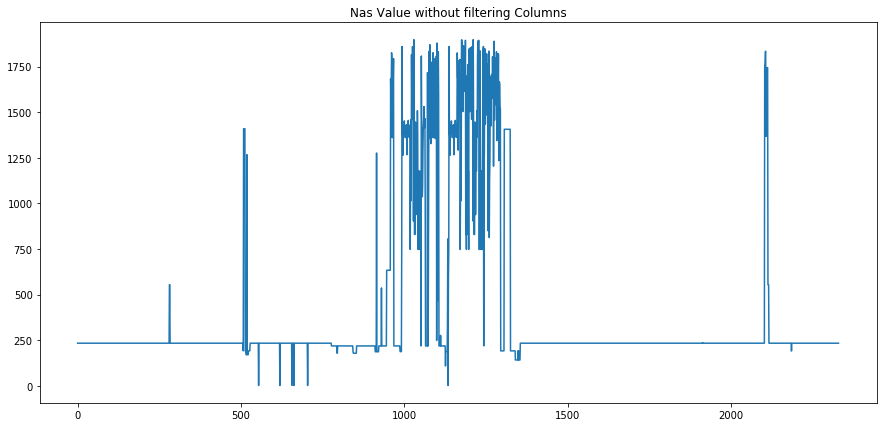

Stat : Min: 1.000000 25%: 233.000000 Median: 233.000000 75%: 233.000000 Max :1898.000000 Mean: 393.836052 Std: 430.986607
Na Counts: 457885 Na%:  0.12


<Figure size 432x288 with 0 Axes>

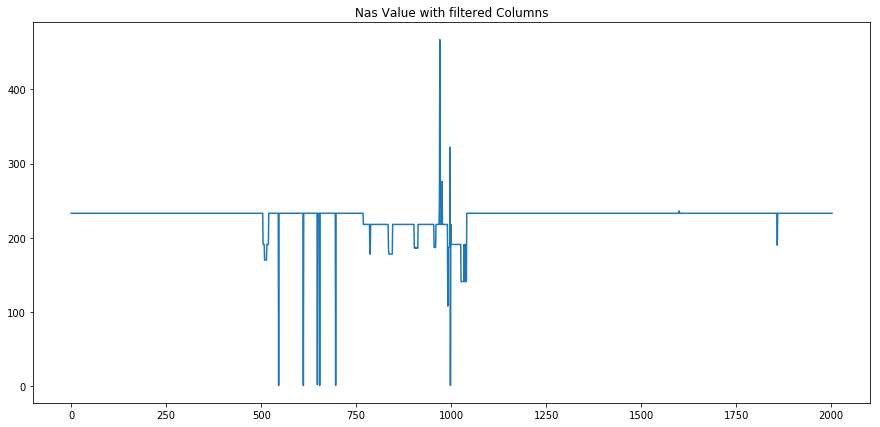

Shape with out dropping Nas
Shape: (1899, 2003) Na Counts: 457885 Na%: 12.04
Shape after dropping Nas
Shape: (1899, 2003) Na Counts: 457885 Na%: 12.04
Columns with zero standard deiviation Index(['ap005537|acxiom_enh_retail_1'], dtype='object')
Columns with very high standard deiviation Index(['ap001286|acxiom_enh_ins_tel_b2b', 'ap001286|acxiom_enh_mde_orig',
       'ap001287|acxiom_enh_mde_orig', 'ap001370|acxiom_enh_mde_orig',
       'ap001371|acxiom_enh_mde_orig', 'ap003645|acxiom_enh_misc_ap'],
      dtype='object')
Columns wich are descrete yet continuous Index(['ap002009|acxiom_enh_cpg', 'ap002037|acxiom_enh_cpg',
       'ap002038|acxiom_enh_cpg', 'ap002089|acxiom_enh_cpg',
       'ap002091|acxiom_enh_cpg', 'ap002096|acxiom_enh_cpg',
       'ap002177|acxiom_enh_cpg', 'ap002271|acxiom_enh_cpg',
       'ap002273|acxiom_enh_cpg', 'ap002274|acxiom_enh_cpg',
       'ap002277|acxiom_enh_cpg', 'ap002381|acxiom_enh_cpg',
       'ap001120|acxiom_enh_ins_tel_b2b', 'ap001133|acxiom_enh_ins_

NameError: name 'sns' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 864x720 with 0 Axes>

In [18]:
oneclass.fit(df_acxiom, df_cdp, field_list)

In [45]:
gc.collect()

84764

In [46]:
oneclass.score([(1234,{"acxiom_enh_retail_3__ap004065": 1, "acxiom_enh_ins_tel_b2b__ap005691": 1,"z104_pageviews": 0, "z100_max_score":0.2 })])

[(1234, 0.24572915377710208)]

In [34]:
oneclass.cdp_models

In [42]:
oneclass.oneclass_models

{'cov': EllipticEnvelope(assume_centered=True, contamination=0.05, random_state=None,
          store_precision=True, support_fraction=0.72),
 'ifs': IsolationForest(behaviour='new', bootstrap=False, contamination=0.05,
         max_features=3, max_samples='auto', n_estimators=50, n_jobs=None,
         random_state=None, verbose=0),
 'lof': LocalOutlierFactor(algorithm='auto', contamination=0.05, leaf_size=2,
           metric='minkowski', metric_params=None, n_jobs=-1,
           n_neighbors=10, novelty=True, p=3)}

In [196]:
oneclass.verbosity = 2

In [45]:
cxiom_enh_retail_3__ap004065                object
acxiom_enh_retail_3__ap004134                object
acxiom_enh_retail_3__ap004894                object
acxiom_enh_retail_3__ap005468                object
acxiom_enh_retail_3__ap005469                object
acxiom_enh_retail_3__ap005470                object
acxiom_enh_retail_3__ap005476                object
acxiom_enh_retail_3__ap005484                object
acxiom_enh_retail_3__ap005485                object
acxiom_enh_retail_3__ap005487                object
acxiom_enh_retail_3__ap005533                object
acxiom_enh_retail_3__ap005534                object
acxiom_enh_retail_3__ap005712

NameError: name 'df' is not defined

In [43]:
# oneclass.use_prediction = 'score'
df_cdp.columns

Index(['z100_max_score', 'z100_pageviews', 'z101_max_score', 'z101_pageviews',
       'z102_max_score', 'z102_pageviews', 'z103_max_score', 'z103_pageviews',
       'z104_max_score', 'z104_pageviews',
       ...
       'z96_pageviews', 'z97_max_score', 'z97_pageviews', 'z98_max_score',
       'z98_pageviews', 'z99_max_score', 'z99_pageviews', 'z9_max_score',
       'z9_pageviews', 'email_address_md5'],
      dtype='object', length=865)

In [30]:
oneclass.scorer_hints()

(1000,
 ['ap001732|acxiom_enh_cpg',
  'ap001733|acxiom_enh_cpg',
  'ap001734|acxiom_enh_cpg',
  'ap001758|acxiom_enh_cpg',
  'ap001760|acxiom_enh_cpg',
  'ap001764|acxiom_enh_cpg',
  'ap001923|acxiom_enh_cpg',
  'ap001924|acxiom_enh_cpg',
  'ap001925|acxiom_enh_cpg',
  'ap001927|acxiom_enh_cpg',
  'ap001929|acxiom_enh_cpg',
  'ap001931|acxiom_enh_cpg',
  'ap001933|acxiom_enh_cpg',
  'ap001935|acxiom_enh_cpg',
  'ap001937|acxiom_enh_cpg',
  'ap001940|acxiom_enh_cpg',
  'ap001942|acxiom_enh_cpg',
  'ap001944|acxiom_enh_cpg',
  'ap001946|acxiom_enh_cpg',
  'ap001948|acxiom_enh_cpg',
  'ap001949|acxiom_enh_cpg',
  'ap001951|acxiom_enh_cpg',
  'ap001952|acxiom_enh_cpg',
  'ap001954|acxiom_enh_cpg',
  'ap001955|acxiom_enh_cpg',
  'ap001956|acxiom_enh_cpg',
  'ap001957|acxiom_enh_cpg',
  'ap001958|acxiom_enh_cpg',
  'ap001959|acxiom_enh_cpg',
  'ap001960|acxiom_enh_cpg',
  'ap001961|acxiom_enh_cpg',
  'ap001962|acxiom_enh_cpg',
  'ap001963|acxiom_enh_cpg',
  'ap001964|acxiom_enh_cpg',
  'ap00

In [49]:
# oneclass.cdp_columns

In [29]:
oneclass.score([(1234,{"acxiom_enh_retail_3__ap004065": 1, "acxiom_enh_ins_tel_b2b__ap005691": 1,"z104_pageviews": 1, "z100_max_score": 1})])

AttributeError: 'Index' object has no attribute 'index'

In [200]:
cdp_dict = {i:0 for i in oneclass.cdp_columns}
cdp_dict2 = cdp_dict.copy()
cdp_dict3 = {i:1 for i in oneclass.cdp_columns}
cdp_dict4 = cdp_dict3.copy()
for i,col_ in enumerate(oneclass.selected_fields):
    cdp_dict2[col_.split('|')[0]] = (oneclass.minmaxer.data_max[i] - oneclass.minmaxer.data_min[i])/2
    cdp_dict4[col_.split('|')[0]] = (oneclass.minmaxer.data_max[i] - oneclass.minmaxer.data_min[i])/2

# cdp_dict['ibe002802'] = 20

In [161]:
print(cdp_dict)

{'z1': 0, 'z2': 0, 'z7': 0, 'z17': 0, 'z33': 0, 'z34': 0, 'z35': 0, 'z37': 0, 'z40': 0, 'z41': 0, 'z45': 0, 'z50': 0, 'z51': 0, 'z55': 0, 'z56': 0, 'z57': 0, 'z58': 0, 'z62': 0, 'z65': 0, 'z72': 0, 'z73': 0, 'z75': 0, 'z82': 0, 'z88': 0, 'z92': 0, 'z98': 0, 'z101': 0, 'z106': 0, 'z107': 0, 'z108': 0, 'z109': 0, 'z110': 0, 'z112': 0, 'z113': 0, 'z115': 0, 'z116': 0, 'z118': 0, 'z119': 0, 'z121': 0, 'z122': 0, 'z123': 0, 'z125': 0, 'z126': 0, 'z127': 0, 'z129': 0, 'z130': 0, 'z131': 0, 'z132': 0, 'z133': 0, 'z145': 0, 'z149': 0, 'z151': 0, 'z153': 0, 'z158': 0, 'z162': 0, 'z163': 0, 'z171': 0, 'z172': 0, 'z184': 0, 'z192': 0, 'z194': 0, 'z195': 0, 'z197': 0, 'z200': 0, 'z202': 0, 'z205': 0, 'z206': 0, 'z208': 0, 'z212': 0, 'z213': 0, 'z215': 0, 'z216': 0, 'z223': 0, 'z226': 0, 'z227': 0, 'z228': 0, 'z229': 0, 'z230': 0, 'z231': 0, 'z232': 0, 'z236': 0, 'z237': 0, 'z238': 0, 'z239': 0, 'z241': 0, 'z243': 0, 'z244': 0, 'z250': 0, 'z251': 0, 'z252': 0, 'z253': 0, 'z254': 0, 'z255': 0, 'z256

In [162]:
print(cdp_dict2)

{'z1': 0, 'z2': 0, 'z7': 0, 'z17': 0, 'z33': 0, 'z34': 0, 'z35': 0, 'z37': 0, 'z40': 0, 'z41': 0, 'z45': 0, 'z50': 0, 'z51': 0, 'z55': 0, 'z56': 0, 'z57': 0, 'z58': 0, 'z62': 0, 'z65': 0, 'z72': 0, 'z73': 0, 'z75': 0, 'z82': 0, 'z88': 0, 'z92': 0, 'z98': 0, 'z101': 0, 'z106': 0, 'z107': 0, 'z108': 0, 'z109': 0, 'z110': 0, 'z112': 0, 'z113': 0, 'z115': 0, 'z116': 0, 'z118': 0, 'z119': 0, 'z121': 0, 'z122': 0, 'z123': 0, 'z125': 0, 'z126': 0, 'z127': 0, 'z129': 0, 'z130': 0, 'z131': 0, 'z132': 0, 'z133': 0, 'z145': 0, 'z149': 0, 'z151': 0, 'z153': 0, 'z158': 0, 'z162': 0, 'z163': 0, 'z171': 0, 'z172': 0, 'z184': 0, 'z192': 0, 'z194': 0, 'z195': 0, 'z197': 0, 'z200': 0, 'z202': 0, 'z205': 0, 'z206': 0, 'z208': 0, 'z212': 0, 'z213': 0, 'z215': 0, 'z216': 0, 'z223': 0, 'z226': 0, 'z227': 0, 'z228': 0, 'z229': 0, 'z230': 0, 'z231': 0, 'z232': 0, 'z236': 0, 'z237': 0, 'z238': 0, 'z239': 0, 'z241': 0, 'z243': 0, 'z244': 0, 'z250': 0, 'z251': 0, 'z252': 0, 'z253': 0, 'z254': 0, 'z255': 0, 'z256

In [212]:
score_data = [(1234,{"ap006095": 100, "ap006094": 20, "z216": 1, "z232": 1,"z424": 1,"z380": 1,"z345": 1,"z440": 1,"z202": 1}),
                (1235,{"ap004107": 1, "ap006094": 1, "z345":1, "z324":1,"z231":1,"z380":1,"z232":1,"z208":1,"z424":1,"z216":1,
                      "z435":1,"z410":1,"z321":1,"z395":1,"z213":1,"z239":1,"z323":1,"z337":1,"z277":1,"z425":1,"z320":1,
                      "z437":1,"z417":1,"z194":1,"z297":1 }),
                (1236,{"ap006095": 1, "ap006094": 1, "z58": 1}),
                (1237,cdp_dict),
                (1238,cdp_dict2),
                (1239,cdp_dict3),
                (1240,cdp_dict4),
                (1241,{}),
                (1242,{'ap006095':-1000})]

In [213]:
oneclass.use_prediction = 'score'
oneclass.do_score_scaling = True
# oneclass.do_scaling = False
oneclass.verbosity = 0
oneclass.score(score_data)

[(1234, 0.322216710821195),
 (1235, 0.10700178913869852),
 (1236, 0.027553111378371097),
 (1237, 0.03591326129956733),
 (1238, 0.26410448845508283),
 (1239, 0.0054135231263437575),
 (1240, 0.05281072662016584),
 (1241, 0.03591326129956733),
 (1242, 0.044655815305608235)]

In [214]:
oneclass.use_prediction = 'predict'
oneclass.do_score_scaling = False
oneclass.score(score_data)

[(1234, 0.04742587317756678),
 (1235, 0.0005527786369235996),
 (1236, 0.0005527786369235996),
 (1237, 0.0005527786369235996),
 (1238, 0.0005527786369235996),
 (1239, 0.0005527786369235996),
 (1240, 0.0005527786369235996),
 (1241, 0.0005527786369235996),
 (1242, 0.0005527786369235996)]

In [215]:
oneclass.use_prediction = 'predict'
oneclass.do_score_scaling = True
oneclass.score(score_data)

[(1234, 0.04742587317756678),
 (1235, 0.0005527786369235996),
 (1236, 0.0005527786369235996),
 (1237, 0.0005527786369235996),
 (1238, 0.0005527786369235996),
 (1239, 0.0005527786369235996),
 (1240, 0.0005527786369235996),
 (1241, 0.0005527786369235996),
 (1242, 0.0005527786369235996)]

In [216]:
oneclass.use_prediction = 'decision'
oneclass.do_score_scaling = False
# oneclass.do_scaling=True
oneclass.score(score_data)

[(1234, 0.10885080030121619),
 (1235, 0.07585818002124355),
 (1236, 0.07585818002124355),
 (1237, 0.07585818002124355),
 (1238, 0.07585818002124355),
 (1239, 0.07585818002124355),
 (1240, 0.07585818002124355),
 (1241, 0.07585818002124355),
 (1242, 0.07585818002124355)]

In [217]:
oneclass.use_prediction = 'decision'
oneclass.do_score_scaling = True
oneclass.score(score_data)

[(1234, 0.924141873954572),
 (1235, 0.8688690664885799),
 (1236, 0.3116018568827215),
 (1237, 0.3521758547304579),
 (1238, 0.7922927164175858),
 (1239, 0.1920078029500369),
 (1240, 0.4627873495702733),
 (1241, 0.3521758547304579),
 (1242, 0.4055237962379445)]

In [77]:
# oneclass.cdp_models[1].coef_

In [11]:
oneclass.components_df.index.shape

(2145,)

In [12]:
oneclass.field_data[oneclass.field_data.FIELD_NAME_HEADER.isin(oneclass.components_df.index)].shape

(0, 18)

In [15]:
# [i.split('|') for i in  oneclass.components_df.index if '|' in i ] 

In [13]:
[i for i in  oneclass.field_data.FIELD_NAME_HEADER if '|' in i ] 

[]

In [16]:
oneclass.cdp_columns.shape,oneclass.cdp_models[1].coef_.shape

((411,), (411,))

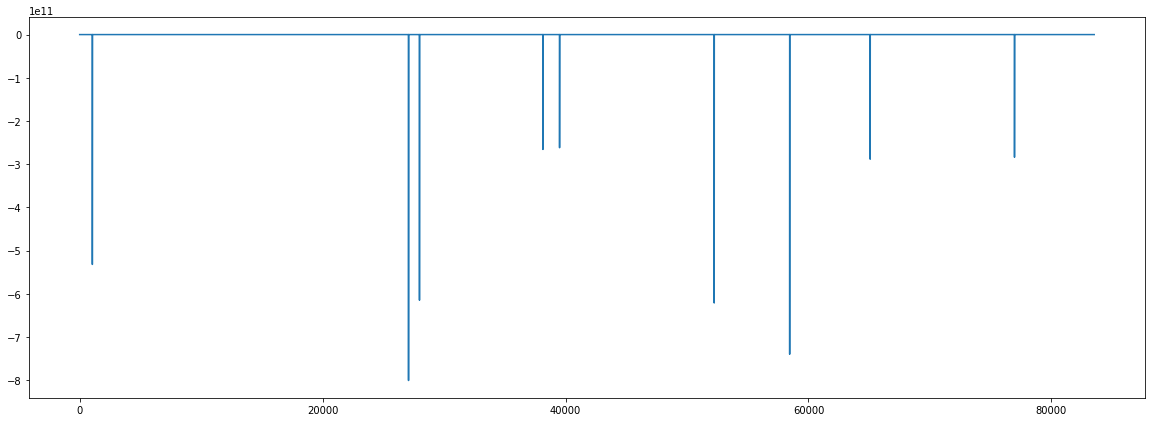

In [16]:
plt.figure(figsize=(20,7))
plt.plot(oneclass.oneclass_models[2].negative_outlier_factor_ + oneclass.oneclass_models[2].offset_)
plt.show()

In [17]:
oneclass.timer_plotter.print_stats(np.log(-oneclass.oneclass_models[2].negative_outlier_factor_),stat_type='full')

Stat : Min: -0.081272 25%: -0.004784 Median: 0.016869 75%: 0.055765 Max :27.408944 Mean: 0.046561 Std: 0.293583


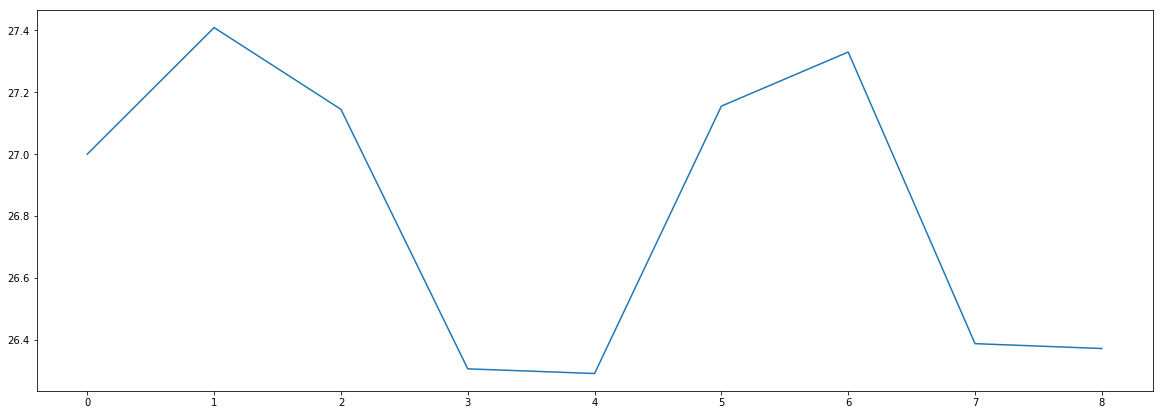

In [22]:
plt.figure(figsize=(20,7))
vals = np.log(-oneclass.oneclass_models[2].negative_outlier_factor_)
plt.plot(vals[vals>10] )
plt.show()

In [20]:
# oneclass.scorer_hints()

In [71]:
unique_cols = np.unique([i.split('|')[0] if str(i).rfind('|') else i for i in oneclass.selected_fields]).tolist()

In [ ]:
oneclass._extract_data({"ap004170": 1, "ap006094": 1})

In [27]:
[i.split('|')[0] for i in oneclass.selected_fields].index('ap006095')

486

In [31]:
# dict_fields = {'X1': 0.1, 'X2': 0.2, 'X3': 0.4, 'X4': 0.09}
dict_fields = {"ap006095": 1, "ap006094": 1}
fields = [i.split('|')[0] for i in oneclass.selected_fields]
folders = [i.split('|')[1] for i in oneclass.selected_fields]
alist = [[fields.index(k), v] for k, v in
         dict_fields.items()]
# alist
# [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
X = np.zeros((1, len(oneclass.selected_fields)))
X[:] = np.nan
for k, v in alist: X[:, k] = v

# dict_fields = {}
# for col_ in dict_fields.keys():
#     if col_ in self.selected_fields:
#         val = dict_fields[col_]



In [34]:
dict_fields = {"z145": 1, "z254": 1}
alist = [[oneclass.cdp_columns.tolist().index(k), v] for k, v in
         dict_fields.items()]
# alist
# [[4, 0.09], [3, 0.4], [1, 0.1], [2, 0.2]]
X = np.zeros((1, len(oneclass.cdp_columns)))
X[:] = np.nan
for k, v in alist: X[:, k] = v
X

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1., nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan

In [57]:
X_acx, X_cdp = oneclass._extract_data({"ap006095": 1, "ap006094": 1,"z145": 1, "z254": 1},[i.split('|')[0] for i in oneclass.selected_fields])

In [58]:
X_acx = pd.DataFrame(X_acx,columns=oneclass.selected_fields)
X_cdp = pd.DataFrame(X_cdp,columns=oneclass.cdp_columns)

In [59]:
X_acx

ap001732|enh_cpg  ap001733|enh_cpg  ap001734|enh_cpg  ap001758|enh_cpg  \
0               NaN               NaN               NaN               NaN   

   ap001760|enh_cpg  ap001764|enh_cpg  ap001923|enh_cpg  ap001924|enh_cpg  \
0               NaN               NaN               NaN               NaN   

   ap001925|enh_cpg  ap001927|enh_cpg             ...              \
0               NaN               NaN             ...               

   foc_tp000169|enh_political  foc_tp000170|enh_political  \
0                         NaN                         NaN   

   foc_tp000171|enh_political  foc_tp000172|enh_political  \
0                         NaN                         NaN   

   foc_tp000173|enh_political  foc_tp000174|enh_political  \
0                         NaN                         NaN   

   foc_tp000175|enh_political  foc_tp000176|enh_political  \
0                         NaN                         NaN   

   foc_tp000177|enh_political  foc_tp000178|enh_political  
0                         NaN                         NaN  

[1 rows x 2140 columns]

In [26]:
X_cdp.fillna(2)

z1   z2   z3   z4   z6   z7   z8   z9  z10  z11  ...   z440  z441  z442  \
0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  ...    2.0   2.0   2.0   

   z443  z444  z448  z450  z451  z452  z453  
0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  

[1 rows x 411 columns]

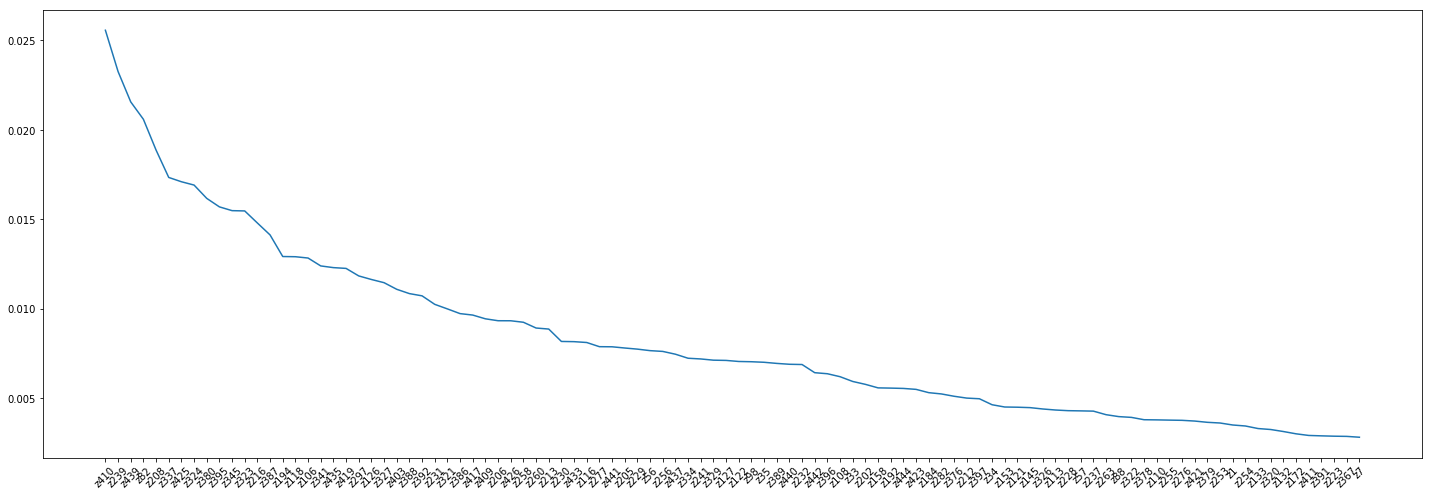

In [203]:
def max_feature(model,cols,num_cols,return_names = False):
    imp = zip(cols,model.feature_importances_)
    imp = sorted(imp,key = lambda x: x[1],reverse=True)
    imp = imp[:num_cols]
    names = [i[0] for i in imp]
    val = [i[1] for i in imp]
    plt.figure(figsize=(20,7))
    plt.plot(names,val)
    plt.xticks(rotation=45)
    plt.tight_layout()
    if return_names:
        return names
max_feature(oneclass.cdp_models[4],oneclass.cdp_columns,100)

In [ ]:
# X_acx, X_cdp = 
oneclass.score([(1234,{"ap006095": 1, "ap006094": 1, "z216": 1, "z232": 1,"z424": 1,"z380": 1,"z345": 1,"z440": 1,"z202": 1}),
                               (1234,{"ap4107": 1, "ap006094": 1, "z345":1, "z324":1,"z231":1,"z380":1,"z232":1,"z208":1,"z424":1,"z216":1,
                                      "z435":1,"z410":1,"z321":1,"z395":1,"z213":1,"z239":1,"z323":1,"z337":1,"z277":1,"z425":1,"z320":1,
                                      "z437":1,"z417":1,"z194":1,"z297":1 }),
                               (1234,{"ap006095": 1, "ap006094": 1, "z58": 1})])
# fillval =9
# # print(oneclass.cdp_models[0].predict(X_cdp.fillna(fillval).values[1:,]),'\n',
# #         oneclass.cdp_models[1].predict(X_cdp.fillna(fillval).values[1:,]),'\n',
# #         oneclass.cdp_models[2].predict(X_cdp.fillna(fillval).values[1:,]),'\n',
# #         oneclass.cdp_models[3].predict(X_cdp.fillna(fillval).values[1:,]),'\n',
# #         oneclass.cdp_models[4].predict(X_cdp.fillna(fillval).values[1:,]),'\n')

# print('\n',oneclass.cdp_models[0].predict(X_cdp.fillna(fillval).values),'\n',
#         oneclass.cdp_models[1].predict(X_cdp.fillna(fillval).values),'\n',
#         oneclass.cdp_models[2].predict(X_cdp.fillna(fillval).values),'\n',
#         oneclass.cdp_models[3].predict(X_cdp.fillna(fillval).values),'\n',
#         oneclass.cdp_models[4].predict(X_cdp.fillna(fillval).values),'\n')

In [135]:
oneclass._transform_acxiom(X_acx)

P_1      P_11       P_2       P_3           P_4       P_5       P_6  \
0 -0.292690 -0.021898 -0.000075 -0.000004 -1.204124e-07 -0.076923 -0.052632   
1  0.470212  0.478102  0.851997  0.999997  5.004634e-01  0.439103  0.447368   
2  0.470212  0.478102  0.851997  0.999997  5.004634e-01  0.439103  0.447368   
3  0.470212  0.478102  0.851997  0.999997  5.004634e-01  0.439103  0.447368   

        P_7  
0 -0.108209  
1  0.440299  
2  0.440299  
3  0.440299

In [136]:
oneclass._transform_cdp(X_cdp)

F_0       F_1  F_2       F_3  F_4       F_5       F_6  F_7  F_8
0  1.0  0.000104  1.0  0.107518  1.0  0.999715  0.053212  1.0  1.0
1  1.0  0.000104  1.0  0.107518  1.0  0.999715  0.053212  1.0  1.0
2  1.0  0.000104  1.0  0.107518  1.0  0.999715  0.053212  1.0  1.0
3  1.0  0.000104  1.0  0.107518  1.0  0.999715  0.053212  1.0  1.0

In [137]:
oneclass._predict(X_acx,X_cdp)

AttributeError: 'Series' object has no attribute 'reshape'

In [19]:
X_tot = np.hstack((oneclass._transform_acxiom(X_acx).values,oneclass._transform_cdp(X_cdp)))
X_tot.shape

(4, 18)

In [20]:
oneclass.oneclass_models

[IsolationForest(behaviour='new', bootstrap=False, contamination=0.1,
         max_features=3, max_samples='auto', n_estimators=50, n_jobs=None,
         random_state=None, verbose=0),
 EllipticEnvelope(assume_centered=True, contamination=0.1, random_state=None,
          store_precision=True, support_fraction=0.72),
 LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=2,
           metric='minkowski', metric_params=None, n_jobs=-1,
           n_neighbors=10, novelty=True, p=3)]

In [21]:
print(oneclass.oneclass_models[0].predict(X_tot),
    oneclass.oneclass_models[1].predict(X_tot),
    oneclass.oneclass_models[2].predict(X_tot))

[1 1 1 1] [1 1 1 1] [-1  1  1  1]


In [22]:
print(oneclass.oneclass_models[0].decision_function(X_tot),
    oneclass.oneclass_models[1].decision_function(X_tot),
    oneclass.oneclass_models[2].decision_function(X_tot))

[0.02059824 0.05780361 0.05780361 0.05780361] [  2.41311303 100.36964773 100.36964773 100.36964773] [-2.34726836  0.2955439   0.2955439   0.2955439 ]


In [23]:
print(oneclass.oneclass_models[0].score_samples(X_tot),
    oneclass.oneclass_models[1].score_samples(X_tot),
    oneclass.oneclass_models[2].score_samples(X_tot))

[-0.47434386 -0.43713849 -0.43713849 -0.43713849] [-108.55910215  -10.60256745  -10.60256745  -10.60256745] [-3.59597108 -0.95315883 -0.95315883 -0.95315883]


In [24]:
df_tot = oneclass.data

In [25]:
df_tot.head()

P_1      P_11       P_2       P_3           P_4       P_5       P_6  \
0  0.470315  0.478102  0.851999  0.999997  5.004634e-01  0.439103  0.447368   
1  0.808882  0.072993  0.000056  0.000008  1.806187e-06  0.185897  0.578947   
2  0.303023  0.656934  0.014457  0.008306  1.875033e-03  0.410256  0.789474   
3  0.475892  0.240876  0.001062  0.000343  9.632996e-07  0.467949  0.157895   
4  0.680785  0.481752  0.000136  0.000009  2.047012e-06  0.230769  0.315789   

        P_7                 email_address_md5             0         1  \
0  0.440299  044b267b872cf560e145b34c3a40102d  1.000000e+00  0.999992   
1  0.208955  1617d98eac0e88f39861cb459499aba9  1.000000e+00  0.999971   
2  0.328358  0b5ec1037e7a4560dc29bf527d1edf63  1.000000e+00  0.982997   
3  0.283582  2156d7201a590c349d201905125e72de  6.351047e-25  0.999998   
4  0.485075  0efed084ec7cb1b21c0259df4acfcd0c  1.000000e+00  0.999939   

              2             3         4             5             6  \
0  1.261013e-01  9.995587e-01  0.000007  1.000000e+00  4.930268e-14   
1  3.921502e-03  1.153281e-07  0.003430  3.229708e-13  1.201496e-12   
2  9.975585e-01  7.185808e-07  0.000072  1.000000e+00  5.933292e-09   
3  2.730517e-15  9.670360e-01  0.008577  2.650266e-23  2.184983e-07   
4  6.141680e-01  9.897357e-01  0.999681  6.778814e-25  1.706466e-08   

              7         8         9  
0  9.999969e-01  1.000000  0.000010  
1  9.998222e-01  1.000000  0.000129  
2  3.321548e-11  0.999802  0.162208  
3  1.236145e-05  0.999997  0.995736  
4  8.181990e-10  0.999633  0.000250

In [27]:
X_train, X_test = train_test_split(df_tot.drop('email_address_md5',axis=1).values, test_size=0.2)
        
# Fitting one class model
mod_lof = LocalOutlierFactor(contamination=oneclass.contamination, n_jobs=-1, p=3,novelty=True,
                             leaf_size=2, n_neighbors=10)
mod_if = IsolationForest(behaviour="new",n_estimators=50, max_features=3,
                            contamination=oneclass.contamination)
mod_cov = EllipticEnvelope(support_fraction=0.72, assume_centered=True,
                           contamination=oneclass.contamination)


mod_lof.fit(X_train)
mod_if.fit(X_train)
mod_cov.fit(X_train)


/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-78.774407130218336 > -92.996057762109814). You may want to try with a higher value of support_fraction (current value: 0.720).
  RuntimeWarning)
/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-77.551863246491848 > -93.745021856741133). You may want to try with a higher value of support_fraction (current value: 0.720).
  RuntimeWarning)
/Users/jitins_lab/anaconda2/envs/hyper/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:171: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-80.690118137561967 > -92.989664944477425). You may want to try with a higher val

EllipticEnvelope(assume_centered=True, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=0.72)

In [28]:
df_norm = pd.DataFrame(
    {'if_score': mod_if.predict(df_tot.drop('email_address_md5',axis=1).values),
     'cov_score': mod_cov.predict(df_tot.drop('email_address_md5',axis=1).values),
     'lof_score': mod_lof.predict(df_tot.drop('email_address_md5',axis=1).values)})
df_norm['score'] = df_norm[
    ['if_score', 'cov_score', 'lof_score']].sum(axis=1)

In [31]:
df_norm.corr()

if_score  cov_score  lof_score     score
if_score   1.000000   0.238147   0.145742  0.711361
cov_score  0.238147   1.000000   0.065778  0.672258
lof_score  0.145742   0.065778   1.000000  0.590211
score      0.711361   0.672258   0.590211  1.000000

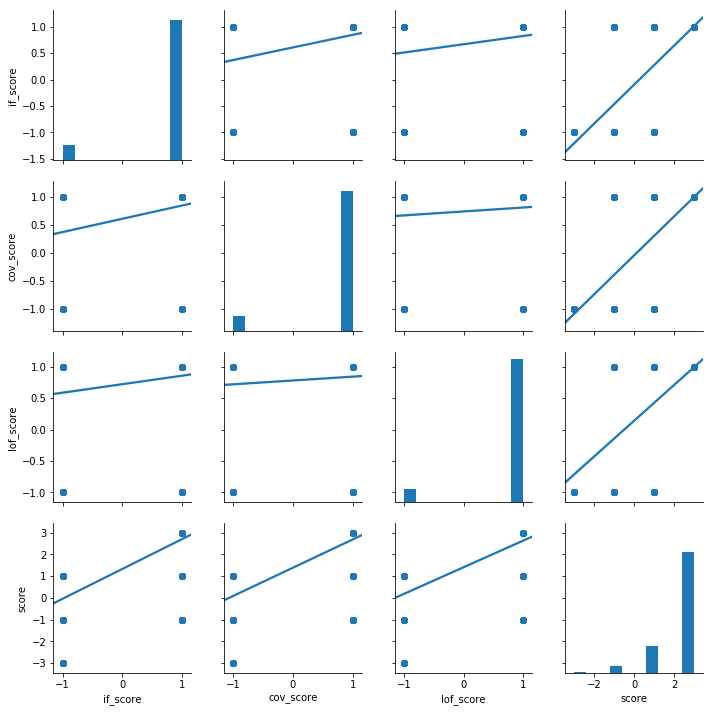

In [30]:
sns.pairplot(df_norm,kind='reg')

In [32]:
df_scored = df_tot.copy()
df_scored['score'] = df_norm['score'] 

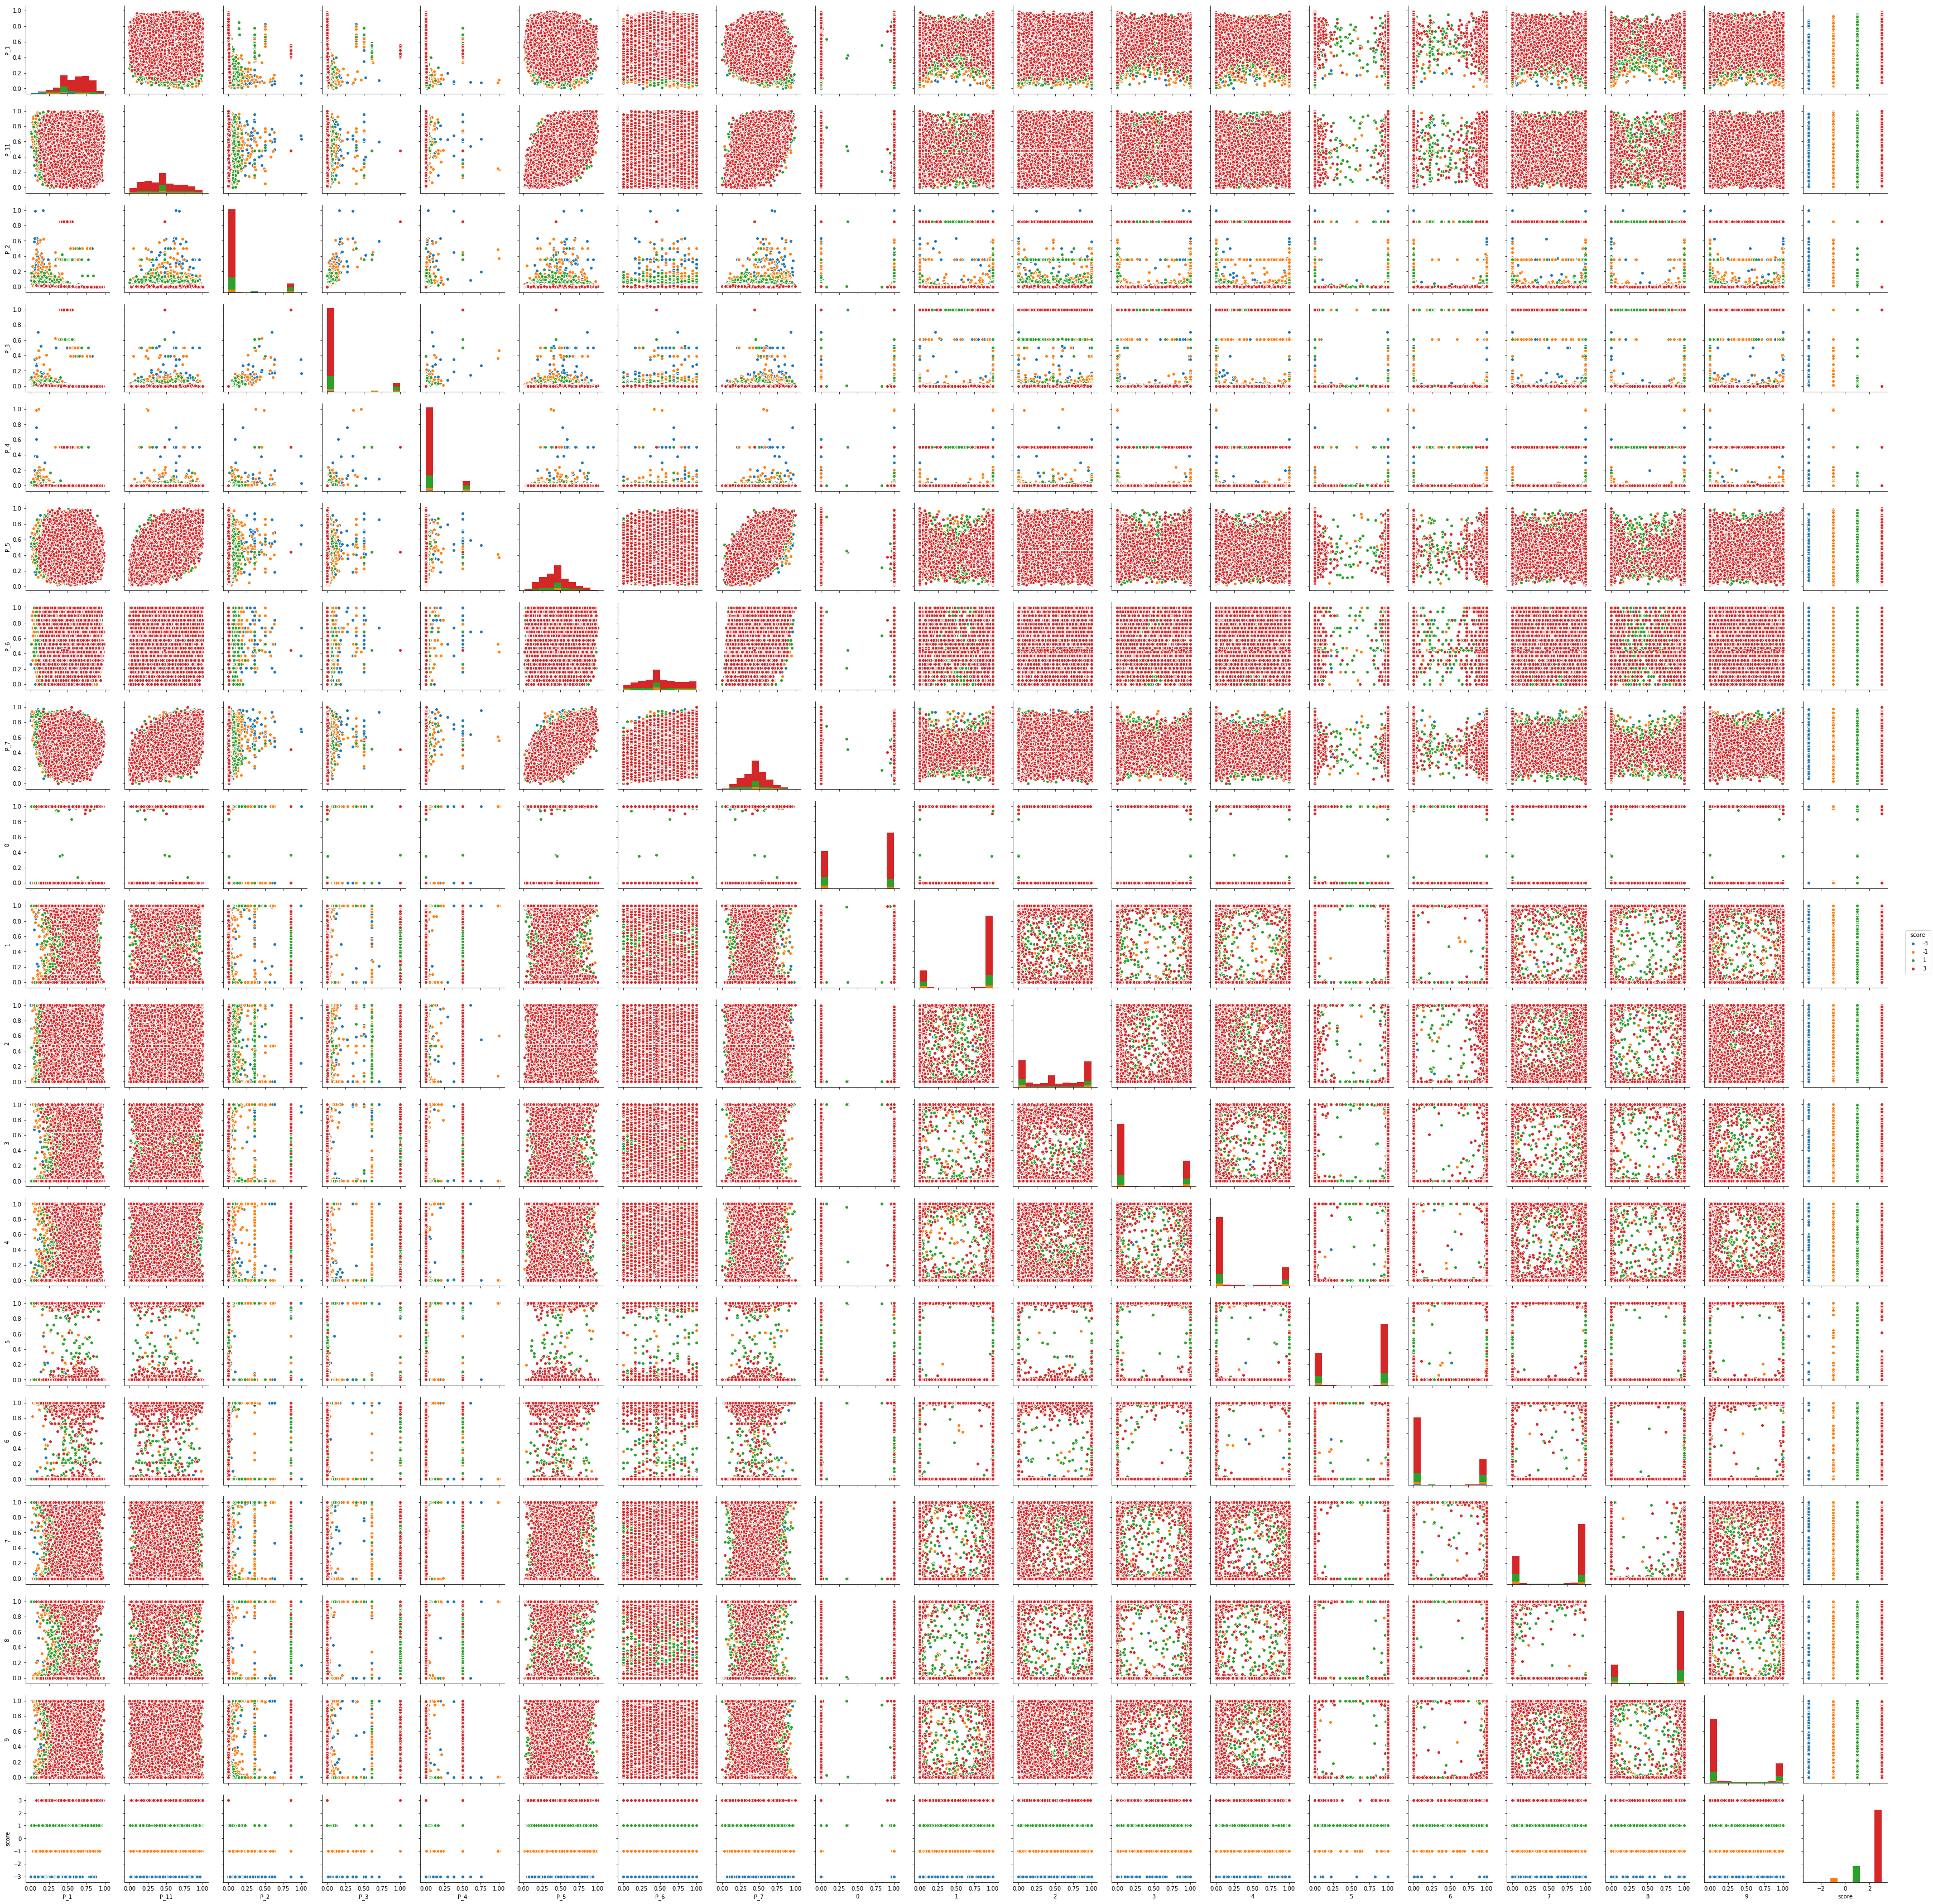

In [33]:
sns.pairplot(df_scored.drop('email_address_md5',axis=1),hue='score')

In [54]:
df_scores = pd.DataFrame(
    {'if_score': mod_if.decision_function(df_tot.drop('email_address_md5',axis=1).values),
     'cov_score': mod_cov.decision_function(df_tot.drop('email_address_md5',axis=1).values),
     'lof_score': mod_lof.decision_function(df_tot.drop('email_address_md5',axis=1).values)})

print(df_scores.describe())



           if_score     cov_score     lof_score
count  49805.000000  4.980500e+04  4.980500e+04
mean       0.060482 -5.655968e+03 -2.866270e+04
std        0.044008  7.796795e+04  3.993259e+06
min       -0.120572 -9.147682e+06 -8.472905e+08
25%        0.030220  7.403698e+01  1.511581e-01
50%        0.064013  8.945566e+01  2.172570e-01
75%        0.095646  9.726093e+01  2.507191e-01
max        0.144498  1.079928e+02  3.823203e-01


In [55]:
df_scores.max(),df_scores.min()

(if_score       0.144498
 cov_score    107.992778
 lof_score      0.382320
 dtype: float64, if_score    -1.205718e-01
 cov_score   -9.147682e+06
 lof_score   -8.472905e+08
 dtype: float64)

In [47]:
# df_scores['cov_score'] =  (df_scores['cov_score'].max() - df_scores['cov_score']) + 1
# df_scores['lof_score'] =  (df_scores['lof_score'].max() - df_scores['lof_score']) + 1
# df_scores.describe()

In [67]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [68]:
# df_scores['cov_score_log'] =  -np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) 
# df_scores['lof_score_log'] =  -np.log1p(df_scores['lof_score'].max() - df_scores['lof_score'])
df_scores['cov_score_log'] =  sigmoid(df_scores['cov_score'])
df_scores['lof_score_log'] =  sigmoid(df_scores['lof_score'])

In [69]:
df_scores.describe()

if_score     cov_score     lof_score  cov_score_log  lof_score_log
count  49805.000000  4.980500e+04  4.980500e+04   49805.000000   49805.000000
mean       0.060482 -5.655968e+03 -2.866270e+04       0.899823       0.537693
std        0.044008  7.796795e+04  3.993259e+06       0.296485       0.063493
min       -0.120572 -9.147682e+06 -8.472905e+08       0.000000       0.000000
25%        0.030220  7.403698e+01  1.511581e-01       1.000000       0.537718
50%        0.064013  8.945566e+01  2.172570e-01       1.000000       0.554102
75%        0.095646  9.726093e+01  2.507191e-01       1.000000       0.562353
max        0.144498  1.079928e+02  3.823203e-01       1.000000       0.594433

In [70]:
score_scaler = MinMaxScaler(feature_range=(-5, 5)).fit(df_scores.values)
df_norm = pd.DataFrame(score_scaler.transform(df_scores.values),
                       columns=df_scores.columns)
# df_norm.lof_distance = - df_norm.lof_distance


df_norm['score'] = df_norm[
    ['if_score', 'cov_score_log', 'lof_score_log']].sum(axis=1)

In [71]:
df_norm.corr()

if_score  cov_score  lof_score  cov_score_log  lof_score_log  \
if_score       1.000000   0.099958   0.000411       0.313541       0.223810   
cov_score      0.099958   1.000000  -0.000530       0.223401       0.170745   
lof_score      0.000411  -0.000530   1.000000      -0.002425       0.060786   
cov_score_log  0.313541   0.223401  -0.002425       1.000000       0.078817   
lof_score_log  0.223810   0.170745   0.060786       0.078817       1.000000   
score          0.684753   0.244643   0.014141       0.864043       0.405055   

                  score  
if_score       0.684753  
cov_score      0.244643  
lof_score      0.014141  
cov_score_log  0.864043  
lof_score_log  0.405055  
score          1.000000

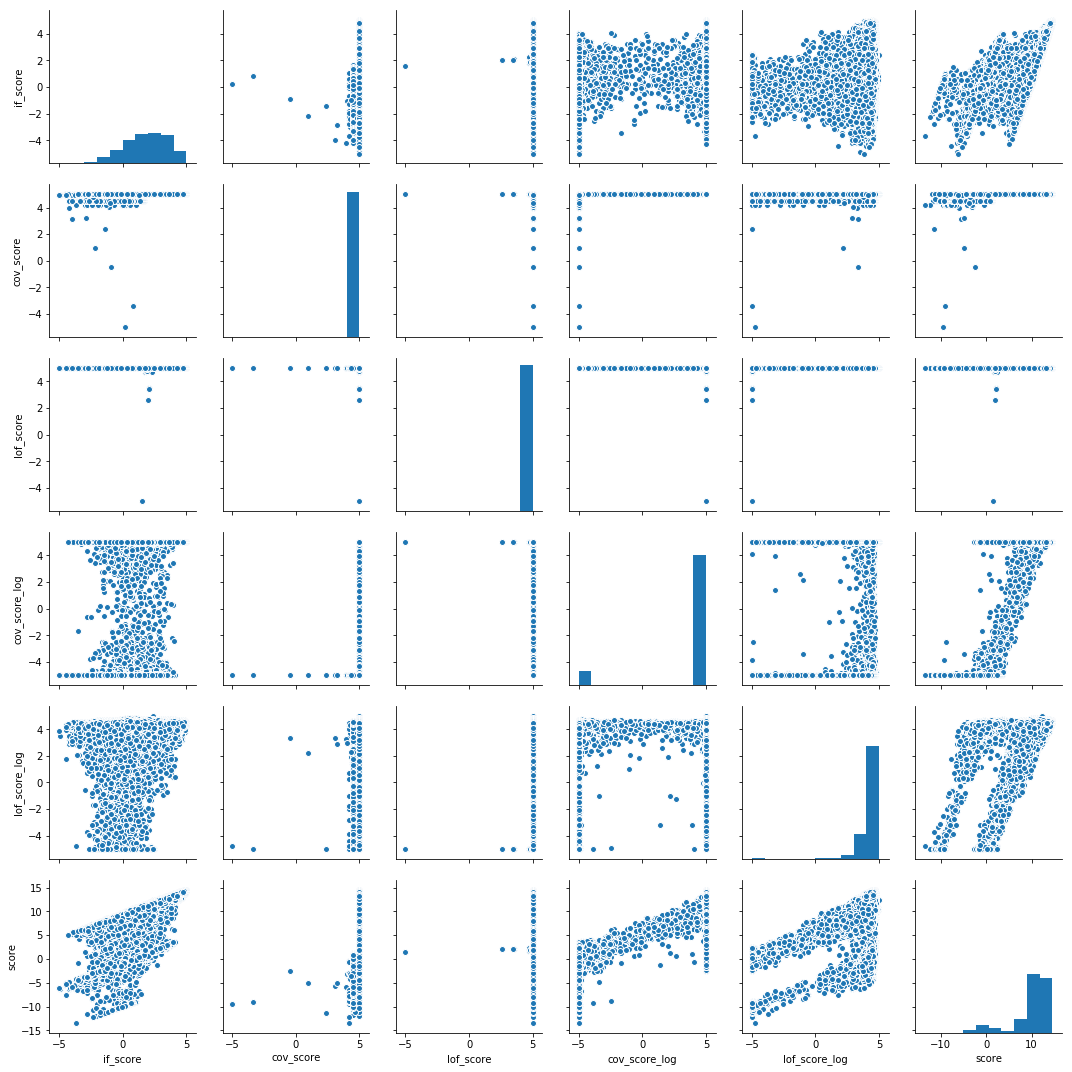

In [72]:
sns.pairplot(df_norm)

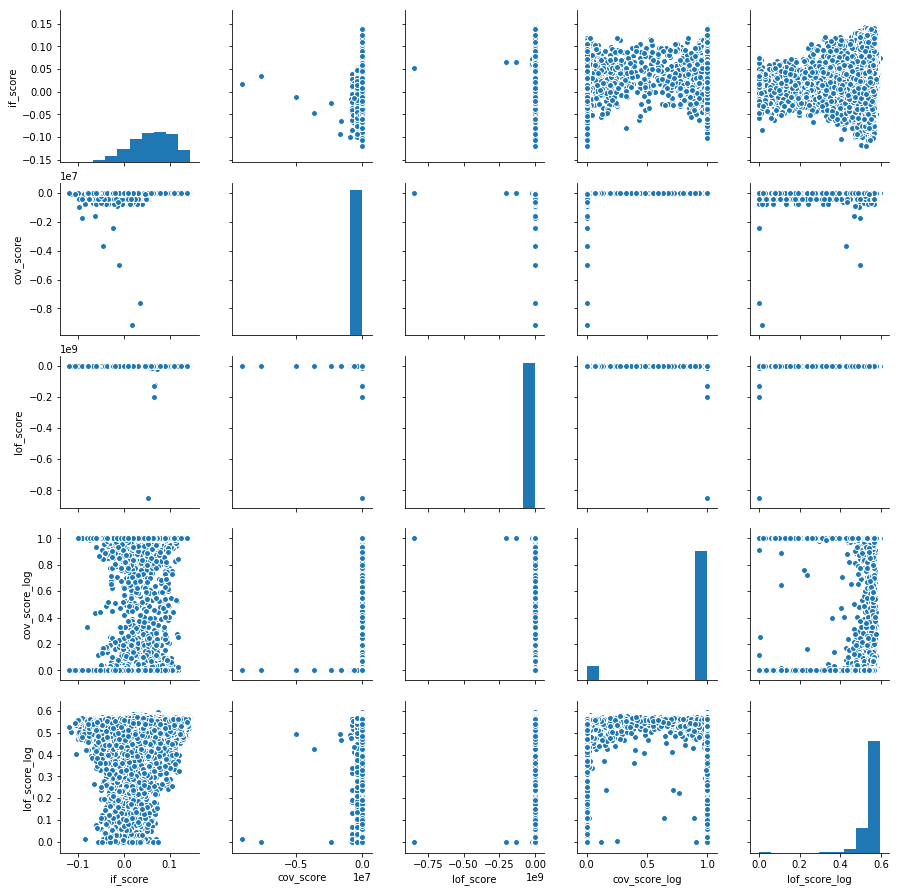

In [73]:
sns.pairplot(df_scores)

In [74]:
df_scores = pd.DataFrame(
    {'if_score': mod_if.score_samples(df_tot.drop('email_address_md5',axis=1).values),
     'cov_score': mod_cov.score_samples(df_tot.drop('email_address_md5',axis=1).values),
     'lof_score': mod_lof.score_samples(df_tot.drop('email_address_md5',axis=1).values)})

In [100]:
eps = 1

In [101]:
df_scores['cov_score_log'] =  1/(np.log1p(df_scores['cov_score'].max() - df_scores['cov_score']) +eps)
df_scores['lof_score_log'] =  1/(np.log1p(df_scores['lof_score'].max() - df_scores['lof_score']) +eps)
# df_scores['cov_score_log'] =  sigmoid(df_scores['cov_score'])
# df_scores['lof_score_log'] =  sigmoid(df_scores['lof_score'])
# df_scores['cov_score_log'] =  1/(df_scores['cov_score'])
# df_scores['lof_score_log'] =  1(df_scores['lof_score'])

In [102]:
df_scores.describe()

if_score     cov_score     lof_score  cov_score_log  lof_score_log
count  49805.000000  4.980500e+04  4.980500e+04   49805.000000   49805.000000
mean      -0.433312 -5.766370e+03 -2.866394e+04       0.255776       0.844531
std        0.044008  7.796795e+04  3.993259e+06       0.069972       0.080711
min       -0.614366 -9.147792e+06 -8.472905e+08       0.058723       0.046387
25%       -0.463574 -3.636508e+01 -1.097712e+00       0.219583       0.827843
50%       -0.429781 -2.094640e+01 -1.031613e+00       0.251742       0.867472
75%       -0.398149 -1.314113e+01 -9.981507e-01       0.288825       0.889970
max       -0.349296 -2.409279e+00 -8.665494e-01       1.000000       1.000000

In [118]:
score_scaler = MinMaxScaler(feature_range=(-10, 10)).fit(df_scores.values)
df_norm = pd.DataFrame(score_scaler.transform(df_scores.values),
                       columns=df_scores.columns)
# df_norm.lof_distance = - df_norm.lof_distance


df_norm['score_minmax'] = MinMaxScaler().fit_transform(df_norm[['if_score', 'cov_score_log', 'lof_score_log']].sum(axis=1).values.reshape(-1, 1))
df_norm['score_sum'] = df_norm[['if_score', 'cov_score_log', 'lof_score_log']].sum(axis=1)
df_norm['score_sig'] = sigmoid(df_norm[['if_score', 'cov_score_log', 'lof_score_log']].sum(axis=1))
df_norm['score_tanh'] = np.tanh(df_norm[['if_score', 'cov_score_log', 'lof_score_log']].sum(axis=1))

df_norm.corr()

if_score  cov_score  lof_score  cov_score_log  lof_score_log  \
if_score       1.000000   0.099958   0.000411       0.655882       0.251009   
cov_score      0.099958   1.000000  -0.000530       0.194625       0.144973   
lof_score      0.000411  -0.000530   1.000000      -0.005608       0.070787   
cov_score_log  0.655882   0.194625  -0.005608       1.000000       0.142490   
lof_score_log  0.251009   0.144973   0.070787       0.142490       1.000000   
score_minmax   0.923706   0.169589   0.022083       0.764284       0.535785   
score_sum      0.923706   0.169589   0.022083       0.764284       0.535785   
score_sig      0.777234   0.158947   0.018043       0.488279       0.516532   
score_tanh     0.724518   0.151875   0.016967       0.446364       0.492988   

               score_minmax  score_sum  score_sig  score_tanh  
if_score           0.923706   0.923706   0.777234    0.724518  
cov_score          0.169589   0.169589   0.158947    0.151875  
lof_score          0.022083   0.022083   0.018043    0.016967  
cov_score_log      0.764284   0.764284   0.488279    0.446364  
lof_score_log      0.535785   0.535785   0.516532    0.492988  
score_minmax       1.000000   1.000000   0.818155    0.763910  
score_sum          1.000000   1.000000   0.818155    0.763910  
score_sig          0.818155   0.818155   1.000000    0.988334  
score_tanh         0.763910   0.763910   0.988334    1.000000

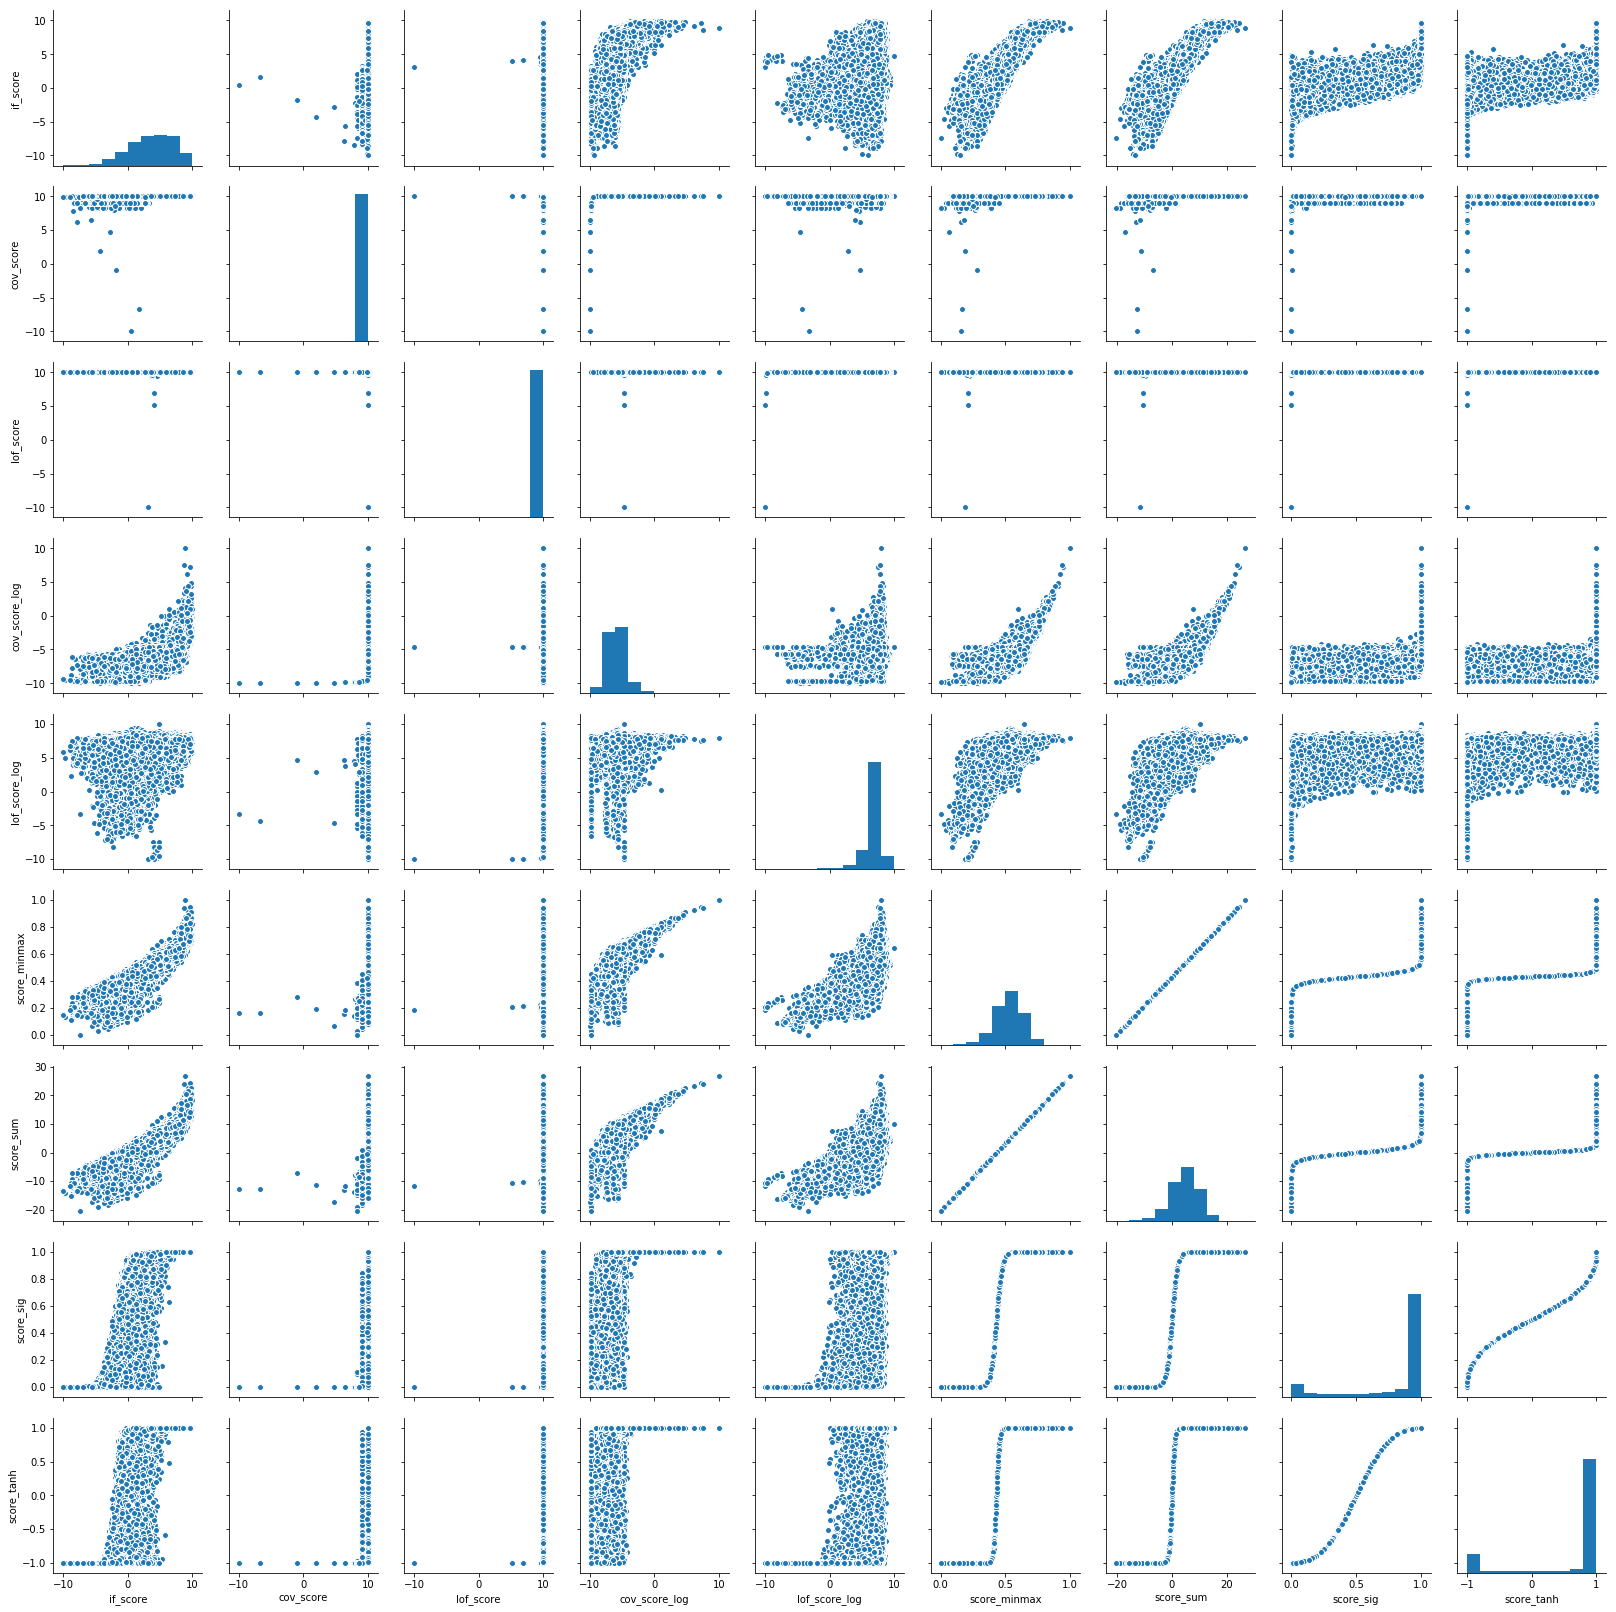

In [119]:
sns.pairplot(df_norm)

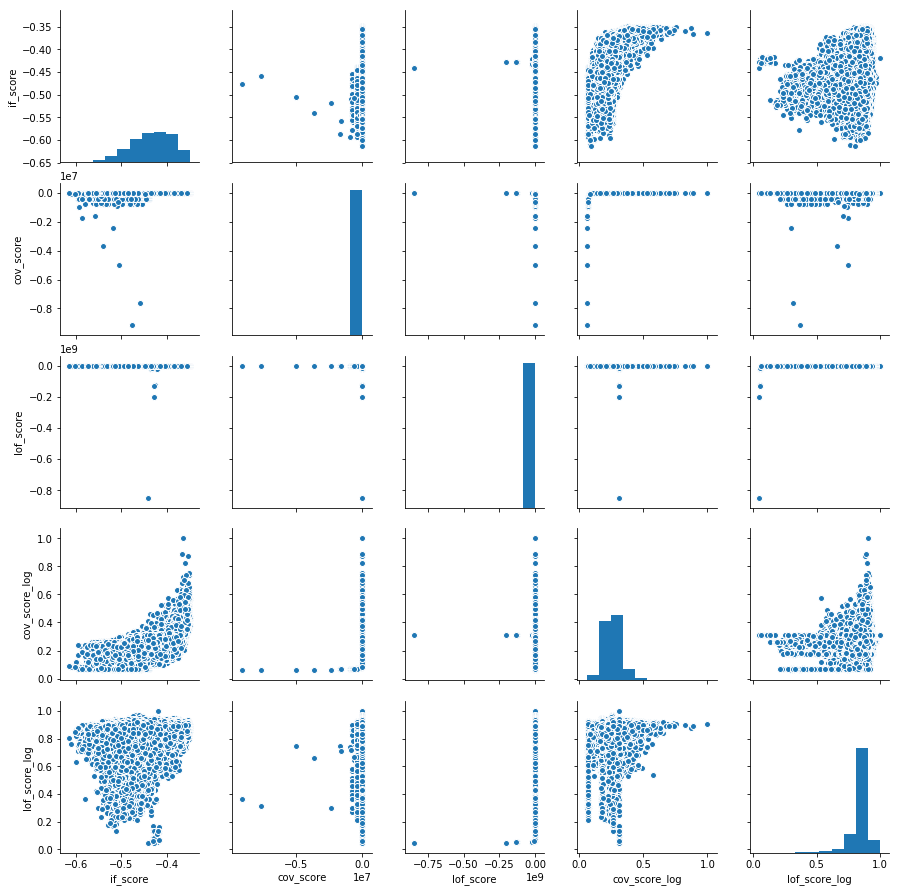

In [120]:
sns.pairplot(df_scores)

In [121]:
df_scored['score'] = df_norm.score_sig

In [ ]:
sns.pairplot(df_scored, hue = 'score')

KeyboardInterrupt: 

In [81]:
mu = 0.896716
# mu = 0.875621 
sigma = 0.085852
mu +sigma, mu +2*sigma, mu + 3*sigma, mu - sigma, mu - 2*sigma,mu -3*sigma

(0.982568, 1.06842, 1.154272, 0.8108639999999999, 0.725012, 0.63916)

In [168]:
a = np.array([1,2,3,4])
a.reshape(-1)

array([1, 2, 3, 4])

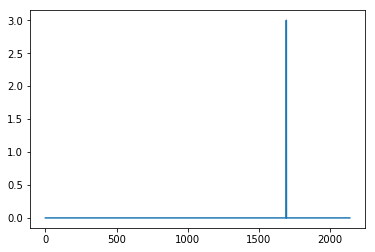

In [205]:
plt.plot(np.sum(np.isnan(oneclass.minmaxer.transform(X_acx,do_transform=False)),axis=0))

In [206]:
np.array(oneclass.selected_fields)[np.sum(np.isnan(oneclass.minmaxer.transform(X_acx,do_transform=False)),axis=0)>0]

array(['ibe2802_ita_score_zip_plus4_aggregate_precision_level|enh_mde_orig'],
      dtype='<U66')

In [208]:
X_acx = pd.DataFrame(oneclass.minmaxer.transform(X_acx,do_transform=False),columns=oneclass.selected_fields)
X_acx

ap001732|enh_cpg  ap001733|enh_cpg  ap001734|enh_cpg  ap001758|enh_cpg  \
0               0.0               0.0               0.0               0.0   
1               9.5              49.5               9.5               9.5   
2               9.5              49.5               9.5               9.5   
3               9.5              49.5               9.5               9.5   

   ap001760|enh_cpg  ap001764|enh_cpg  ap001923|enh_cpg  ap001924|enh_cpg  \
0               0.0               0.0               0.0               0.0   
1              49.5               9.5               4.5               4.5   
2              49.5               9.5               4.5               4.5   
3              49.5               9.5               4.5               4.5   

   ap001925|enh_cpg  ap001927|enh_cpg             ...              \
0               0.0               0.0             ...               
1               9.5              49.5             ...               
2               9.5              49.5             ...               
3               9.5              49.5             ...               

   foc_tp000169|enh_political  foc_tp000170|enh_political  \
0                         0.0                         0.0   
1                        49.5                        49.5   
2                        49.5                        49.5   
3                        49.5                        49.5   

   foc_tp000171|enh_political  foc_tp000172|enh_political  \
0                         0.0                         0.0   
1                        49.5                        49.5   
2                        49.5                        49.5   
3                        49.5                        49.5   

   foc_tp000173|enh_political  foc_tp000174|enh_political  \
0                         0.0                         0.0   
1                        49.5                        49.5   
2                        49.5                        49.5   
3                        49.5                        49.5   

   foc_tp000175|enh_political  foc_tp000176|enh_political  \
0                         0.0                         0.0   
1                        49.5                        49.5   
2                        49.5                        49.5   
3                        49.5                        49.5   

   foc_tp000177|enh_political  foc_tp000178|enh_political  
0                         0.0                         0.0  
1                        49.5                        49.5  
2                        49.5                        49.5  
3                        49.5                        49.5  

[4 rows x 2140 columns]

In [230]:
print(oneclass.oneclass_models[0].predict(oneclass._transform_acxiom(X_acx.fillna(0))),
    oneclass.oneclass_models[1].predict(oneclass._transform_acxiom(X_acx.fillna(0))),
    oneclass.oneclass_models[2].predict(oneclass._transform_acxiom(X_acx.fillna(0))))

       P_1  P_11         P_2         P_3         P_4   P_5  P_6    P_7
0      0.0   0.0         0.0         0.0         0.0   0.0  0.0    0.0
1  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
2  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
3  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
       P_1  P_11         P_2         P_3         P_4   P_5  P_6    P_7
0      0.0   0.0         0.0         0.0         0.0   0.0  0.0    0.0
1  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
2  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
3  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
       P_1  P_11         P_2         P_3         P_4   P_5  P_6    P_7
0      0.0   0.0         0.0         0.0         0.0   0.0  0.0    0.0
1  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
2  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
3  148

       P_1  P_11         P_2         P_3         P_4   P_5  P_6    P_7
0      0.0   0.0         0.0         0.0         0.0   0.0  0.0    0.0
1  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
2  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0
3  14842.5  68.5  55577070.5  87398710.5  16624975.0  80.5  9.5  147.0


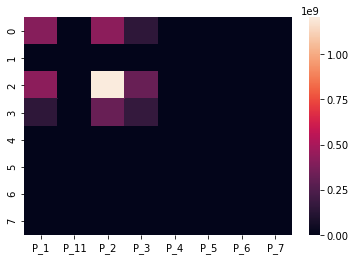

In [232]:
sns.heatmap(pd.DataFrame(oneclass.oneclass_models[1].covariance_,columns=oneclass._transform_acxiom(X_acx.fillna(0)).columns))

In [260]:
np.array([np.hstack((i,k.feature_importances_)).reshape(2,-1) for i,k in zip(oneclass.oneclass_models[0].estimators_features_,oneclass.oneclass_models[0].estimators_)])

array([[[6.        , 0.        , 3.        ],
        [0.20277333, 0.44257287, 0.3546538 ]],

       [[5.        , 7.        , 2.        ],
        [0.25199353, 0.39618677, 0.3518197 ]],

       [[7.        , 6.        , 5.        ],
        [0.33710986, 0.3500057 , 0.31288444]],

       [[1.        , 0.        , 3.        ],
        [0.09857833, 0.54775922, 0.35366245]],

       [[4.        , 5.        , 2.        ],
        [0.20046308, 0.14701167, 0.65252524]],

       [[3.        , 4.        , 7.        ],
        [0.62426836, 0.21488096, 0.16085068]],

       [[0.        , 1.        , 7.        ],
        [0.27881511, 0.39058321, 0.33060168]],

       [[5.        , 1.        , 4.        ],
        [0.43932967, 0.32256835, 0.23810199]],

       [[5.        , 6.        , 1.        ],
        [0.28062866, 0.26098233, 0.45838901]],

       [[5.        , 1.        , 6.        ],
        [0.66899003, 0.18175507, 0.1492549 ]],

       [[2.        , 6.        , 0.        ],
        [0.261

In [277]:
np.array(np.hstack((oneclass.oneclass_models[0].estimators_features_[0].reshape(-1,1),
                    oneclass.oneclass_models[0].estimators_[0].feature_importances_.reshape(-1,1))))

array([[6.        , 0.20277333],
       [0.        , 0.44257287],
       [3.        , 0.3546538 ]])